In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
from scipy.spatial import distance
import pathlib
import os
from sklearn.decomposition import PCA
import json
import random
from random import sample

random.seed(30)

In [2]:
# Set data input folder
input_folder = "inputs"

# Set output folder, subfolder
output_folder = "outputs"
if not os.path.exists(output_folder):
    os.makedirs(output_folder, exist_ok=True)

In [3]:
#load the cell counts from the supplmental_6
A549_counts = pd.read_csv('../Supplemental_6/outputs/A549_WG_Screen_cell_count.csv.gz')
DMEM_counts = pd.read_csv('../Supplemental_6/outputs/HeLa_DMEM_WG_Screen_cell_count.csv.gz')
HPLM_counts = pd.read_csv('../Supplemental_6/outputs/HeLa_HPLM_WG_Screen_cell_count.csv.gz')

#load barcodes used in experiment
guide_df = pd.read_csv('../common_files/Barcodes.csv')
guide_list = list(guide_df['sgRNA'])

# Import the guide-level profiles
A549_df_guide = pd.read_csv("../Profile_Aggregation/outputs/20200805_A549_WG_Screen_guide_normalized_feature_select_merged_median_ALLBATCHES___CP186___ALLWELLS.csv.gz")
DMEM_df_guide = pd.read_csv("../Profile_Aggregation/outputs/20210422_6W_CP257_guide_normalized_feature_select_median_merged_ALLBATCHES___DMEM___ALLWELLS.csv.gz")
DMEM_df_guide = DMEM_df_guide[DMEM_df_guide['Metadata_Foci_Barcode_MatchedTo_Barcode'].isin(guide_list)]

HPLM_df_guide = pd.read_csv("../Profile_Aggregation/outputs/20210422_6W_CP257_guide_normalized_feature_select_median_merged_ALLBATCHES___HPLM___ALLWELLS.csv.gz")
HPLM_df_guide = HPLM_df_guide[HPLM_df_guide['Metadata_Foci_Barcode_MatchedTo_Barcode'].isin(guide_list)]

# Load p_values from the hit calling process
A549_df_p_values = pd.read_csv('../Hit_Calling/outputs/A549_significant_features_mann_whitney_p_values.csv.gz')
A549_df_p_values = A549_df_p_values.rename(columns={'Unnamed: 0':'Gene'}).set_index('Gene')

DMEM_df_p_values = pd.read_csv('../Hit_Calling/outputs/HeLa_DMEM_significant_features_mann_whitney_p_values.csv.gz')
DMEM_df_p_values = DMEM_df_p_values.rename(columns={'Unnamed: 0':'Gene'}).set_index('Gene')

HPLM_df_p_values = pd.read_csv('../Hit_Calling/outputs/HeLa_HPLM_significant_features_mann_whitney_p_values.csv.gz')
HPLM_df_p_values = HPLM_df_p_values.rename(columns={'Unnamed: 0':'Gene'}).set_index('Gene')
    
# Load hits from the hit calling process
A549_whole_cell_hits = pd.read_csv('../Hit_Calling/outputs/A549_plate_level_median_per_feat_sig_genes_5_fdr_whole_cell_hits.csv')
A549_comp_spec_hits = pd.read_csv('../Hit_Calling/outputs/A549_plate_level_median_per_feat_sig_genes_5_fdr_compartment_specific_hits.csv')
A549_all_hits = pd.concat([A549_whole_cell_hits,A549_comp_spec_hits])
A549_hit_list = list(A549_comp_spec_hits.Gene) + list(A549_whole_cell_hits.Gene)
A549_df_guide_hits = A549_df_guide[A549_df_guide['Metadata_Foci_Barcode_MatchedTo_GeneCode'].isin(A549_hit_list)]

DMEM_whole_cell_hits = pd.read_csv('../Hit_Calling/outputs/HeLa_DMEM_plate_level_median_per_feat_sig_genes_5_fdr_whole_cell_hits.csv')
DMEM_comp_spec_hits = pd.read_csv('../Hit_Calling/outputs/HeLa_DMEM_plate_level_median_per_feat_sig_genes_5_fdr_compartment_specific_hits.csv')
DMEM_all_hits = pd.concat([DMEM_whole_cell_hits,DMEM_comp_spec_hits])
DMEM_hit_list = list(DMEM_comp_spec_hits.Gene) + list(DMEM_whole_cell_hits.Gene)
DMEM_df_guide_hits = DMEM_df_guide[DMEM_df_guide['Metadata_Foci_Barcode_MatchedTo_GeneCode'].isin(DMEM_hit_list)]

HPLM_whole_cell_hits = pd.read_csv('../Hit_Calling/outputs/HeLa_HPLM_plate_level_median_per_feat_sig_genes_5_fdr_whole_cell_hits.csv')
HPLM_comp_spec_hits = pd.read_csv('../Hit_Calling/outputs/HeLa_HPLM_plate_level_median_per_feat_sig_genes_5_fdr_compartment_specific_hits.csv')
HPLM_all_hits = pd.concat([HPLM_whole_cell_hits,HPLM_comp_spec_hits])
HPLM_hit_list = list(HPLM_comp_spec_hits.Gene) + list(HPLM_whole_cell_hits.Gene)
HPLM_df_guide_hits = HPLM_df_guide[HPLM_df_guide['Metadata_Foci_Barcode_MatchedTo_GeneCode'].isin(HPLM_hit_list)]


In [4]:
def perform_pca(df_guide_hits):
    df_temp = df_guide_hits.copy(deep=True)
    df_temp['Gene'] = df_temp['Metadata_Foci_Barcode_MatchedTo_GeneCode'] + ' ' + df_temp['Metadata_Foci_Barcode_MatchedTo_Barcode']
    order = ['Gene']+list(df_temp.columns[:-1])
    df_temp = df_temp[order]
    df_temp = df_temp.drop(columns=['Metadata_Foci_Barcode_MatchedTo_GeneCode','Metadata_Foci_Barcode_MatchedTo_Barcode']).set_index('Gene')
    # Perform principal component analysis on hit lists

    pca = PCA()
    pca.fit(df_temp)
    x = list(pca.explained_variance_ratio_)
    # Find principal component that represents 70% variation
    PCA_lookup = {}
    condition = 'A549'
    for i in range(len(x)):
        distance = abs(.7-sum(x[:i+1]))
        PCA_lookup[distance] = i 
    component = PCA_lookup[min(PCA_lookup.keys())]+1
    print (f'For {condition}, principal component representing closest to 70% variation is {component}')
    # Perform principal component analysis and select components representing 80% of variation in data
    pca = PCA(n_components=component)
    df_pca = pd.DataFrame(pca.fit_transform(df_temp),index=df_temp.index)
    df_pca = df_pca.reset_index()
    df_pca[['Metadata_Foci_Barcode_MatchedTo_GeneCode','Metadata_Foci_Barcode_MatchedTo_Barcode']] = df_pca.Gene.str.split(' ', expand = True)
    order = ['Metadata_Foci_Barcode_MatchedTo_GeneCode','Metadata_Foci_Barcode_MatchedTo_Barcode']+list(df_pca.columns[1:-2])
    df_pca = df_pca[order]
    return df_pca


A549_pca_df = perform_pca(A549_df_guide_hits)
DMEM_pca_df = perform_pca(DMEM_df_guide_hits)
HPLM_pca_df = perform_pca(HPLM_df_guide_hits)


HPLM_pca_df

For A549, principal component representing closest to 70% variation is 155
For A549, principal component representing closest to 70% variation is 134
For A549, principal component representing closest to 70% variation is 88


Metadata_Foci_Barcode_MatchedTo_GeneCode  \
0                                        AAED1   
1                                        AAED1   
2                                        AAED1   
3                                        AAED1   
4                                        AAGAB   
...                                        ...   
18626                                   ZYG11B   
18627                                     ZZZ3   
18628                                     ZZZ3   
18629                                     ZZZ3   
18630                                     ZZZ3   

      Metadata_Foci_Barcode_MatchedTo_Barcode          0         1         2  \
0                        CATCTGCAAGGAATACGTAG  -2.218668  4.218320 -5.656111   
1                        GACATGTTATGTCTTACCTG   0.432012  9.032133  1.736299   
2                        GTCATCCTACCATCATATTG  -2.634217  5.601896  5.165648   
3                        TCCCGGAACAGCGCGCCGAA   1.812585  2.285322  4.226822   
4                        ACTGGAACAAACCATAGCAT   3.301543 -1.063601  2.022332   
...                                       ...        ...       ...       ...   
18626                    TCCATCATTCAATAGACCTG  -1.775948  2.339452  1.314627   
18627                    AAGAAGTAGAATCTCGACGC -10.747877  8.571514 -6.158327   
18628                    ACAGACGATTGCTGTACTCG  -7.474902  1.494168  2.783306   
18629                    GACCAATATACCCATAGCCT  -1.764178  0.400984  1.367644   
18630                    GCAGAGTACCCGAGAATCAT  -8.959008 -0.576824  2.295761   

              3         4         5         6         7  ...        78  \
0      1.270263 -1.960169 -3.272265  0.866295 -0.021526  ... -0.599778   
1     -0.321522 -9.680465 -3.658494 -0.262796 -2.250698  ...  0.462108   
2     -0.885544 -2.137007 -0.143419 -1.390891 -1.199343  ...  0.748033   
3     -3.234169  0.360212  1.767326 -3.634698 -0.504466  ...  0.323953   
4     -1.073810 -2.295722  1.592871  2.772708 -1.637289  ...  0.241841   
...         ...       ...       ...       ...       ...  ...       ...   
18626  1.069345  1.676861 -0.065789 -0.602925  0.227549  ...  0.363036   
18627 -4.110147  1.878273 -5.450967  0.385973 -3.553521  ...  0.067809   
18628 -0.448250  1.689440  4.976666  2.783613 -5.745394  ... -0.325996   
18629 -7.767584 -2.135254  0.627260 -0.873279 -1.896341  ... -0.032767   
18630 -3.605895 -0.272351 -2.484253 -0.893985  0.788860  ... -0.563166   

             79        80        81        82        83        84        85  \
0      0.247990 -0.154159  0.152443 -0.090294 -0.704261 -1.210814  0.460626   
1      0.108088 -1.125803  1.579011 -0.458164 -0.976670  0.958403  0.893111   
2      0.217349  0.119321  0.829820 -0.153262 -0.615115  0.118086 -0.651265   
3      0.704632 -0.086680  0.113235  0.651027 -0.579184 -0.047549 -0.139145   
4      0.507008  0.639456  0.505798  0.739915 -0.331772  0.245674  0.791764   
...         ...       ...       ...       ...       ...       ...       ...   
18626 -0.334932 -0.056971  0.135236 -0.005300  0.503768 -0.434309  0.144208   
18627 -0.929388 -2.036218 -1.125425  0.909264  0.403849  0.466121  1.369425   
18628  0.346587 -0.634633  0.769347 -0.464272  0.247512 -0.592053  0.585529   
18629  0.379956 -0.557989 -0.427030 -0.323093 -0.694708  0.031503  0.407284   
18630 -0.820106 -0.002865 -0.225722 -0.097161  0.217436  0.089690  0.104435   

             86        87  
0     -0.212098  0.016924  
1      0.541470 -0.218971  
2     -0.138424  0.736556  
3      0.114357  0.217453  
4     -0.426695 -0.142602  
...         ...       ...  
18626  0.123295  0.198316  
18627 -0.746162  0.054844  
18628 -0.118548  0.604277  
18629 -0.544900 -0.491436  
18630  0.207166  1.062812  

[18631 rows x 90 columns]

In [5]:
# Function to calculate correleations, cluster and draw heatmap 
def heat_map(data,title,file_name,font_scale=0.8):
        corr = data.corr()
        
        plt.clf()
        
        sns.set(font_scale=font_scale,rc={'figure.figsize':(30,30)})

        ax = sns.heatmap(
            corr, 
            vmin=-1, vmax=1, center=0,
            cmap = sns.diverging_palette(250, 10 ,s=100,l=35, n=100),
            linewidth = 0.1,
            linecolor = 'white',
            square = True,
            cbar=False,
            cbar_kws = {"shrink": .76}
        )
        ax.set_xticklabels(
            ax.get_xticklabels(),
            rotation=90,
            horizontalalignment='right'
        )

        ax.set_title(title,fontsize=30)
        plt.tight_layout()
        fig = ax.get_figure()
        plt.show()
        fig.savefig(os.path.join(output_folder,f'{file_name}'),dpi=300)
        

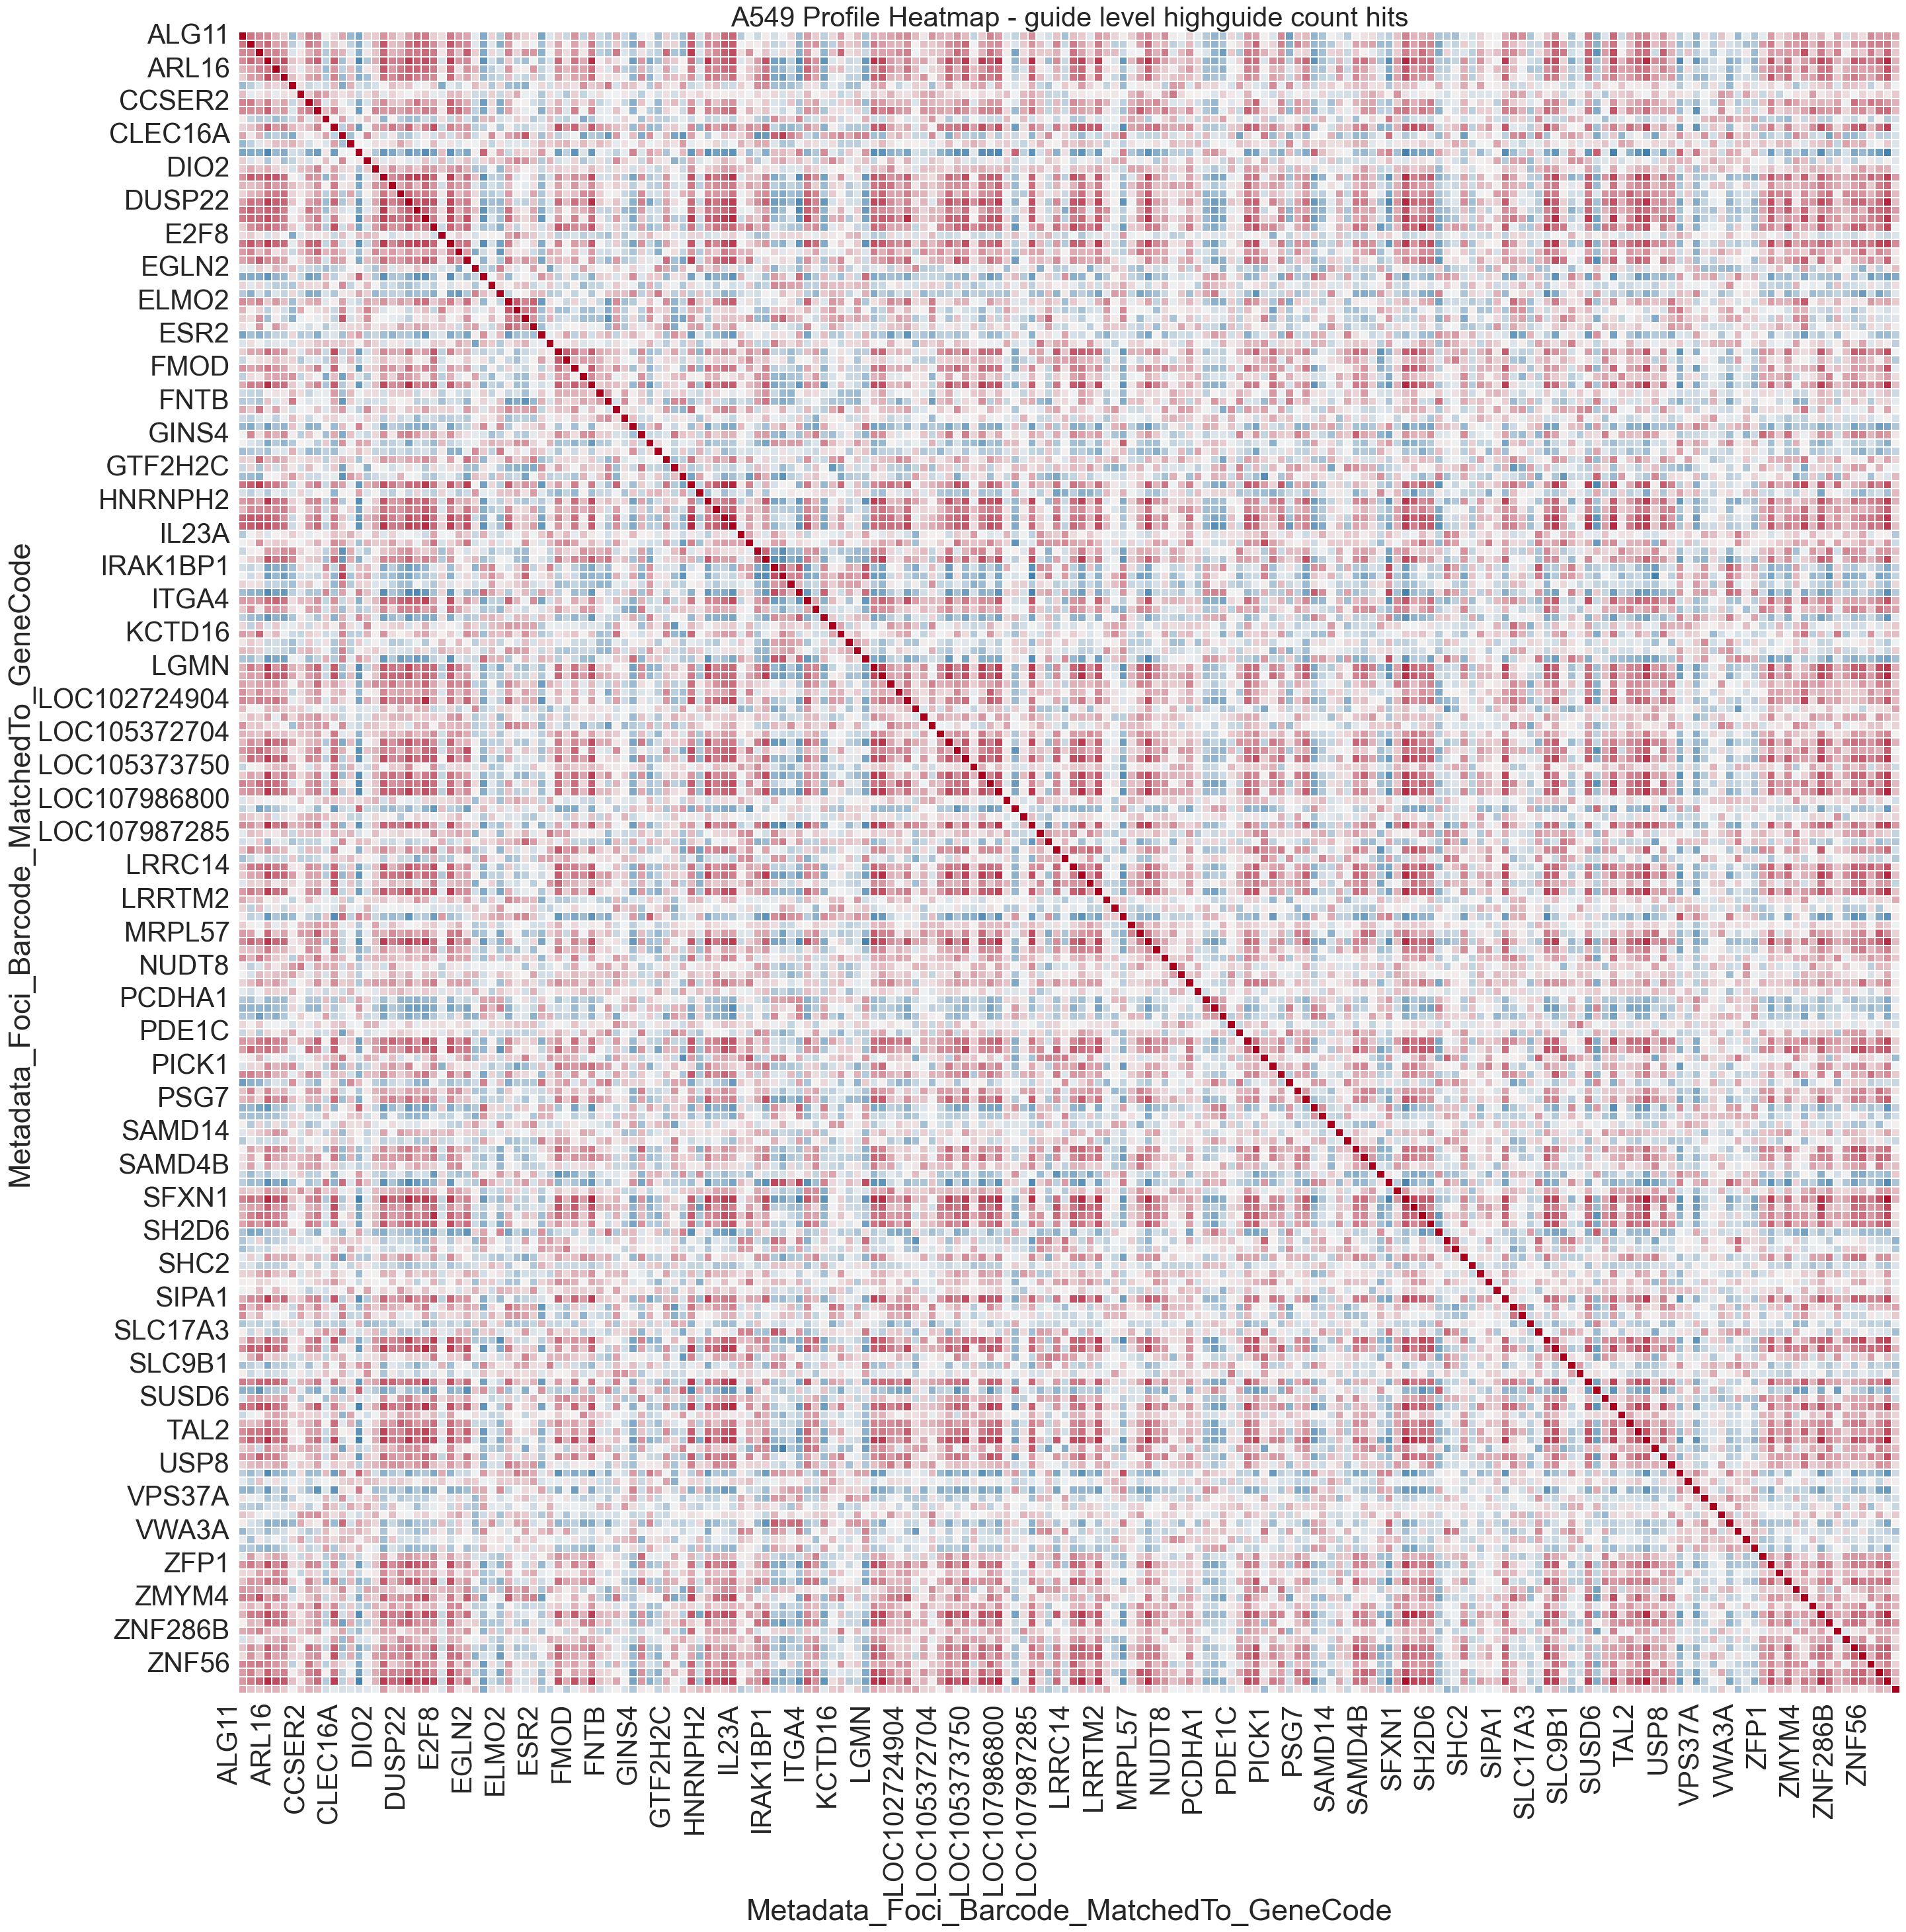

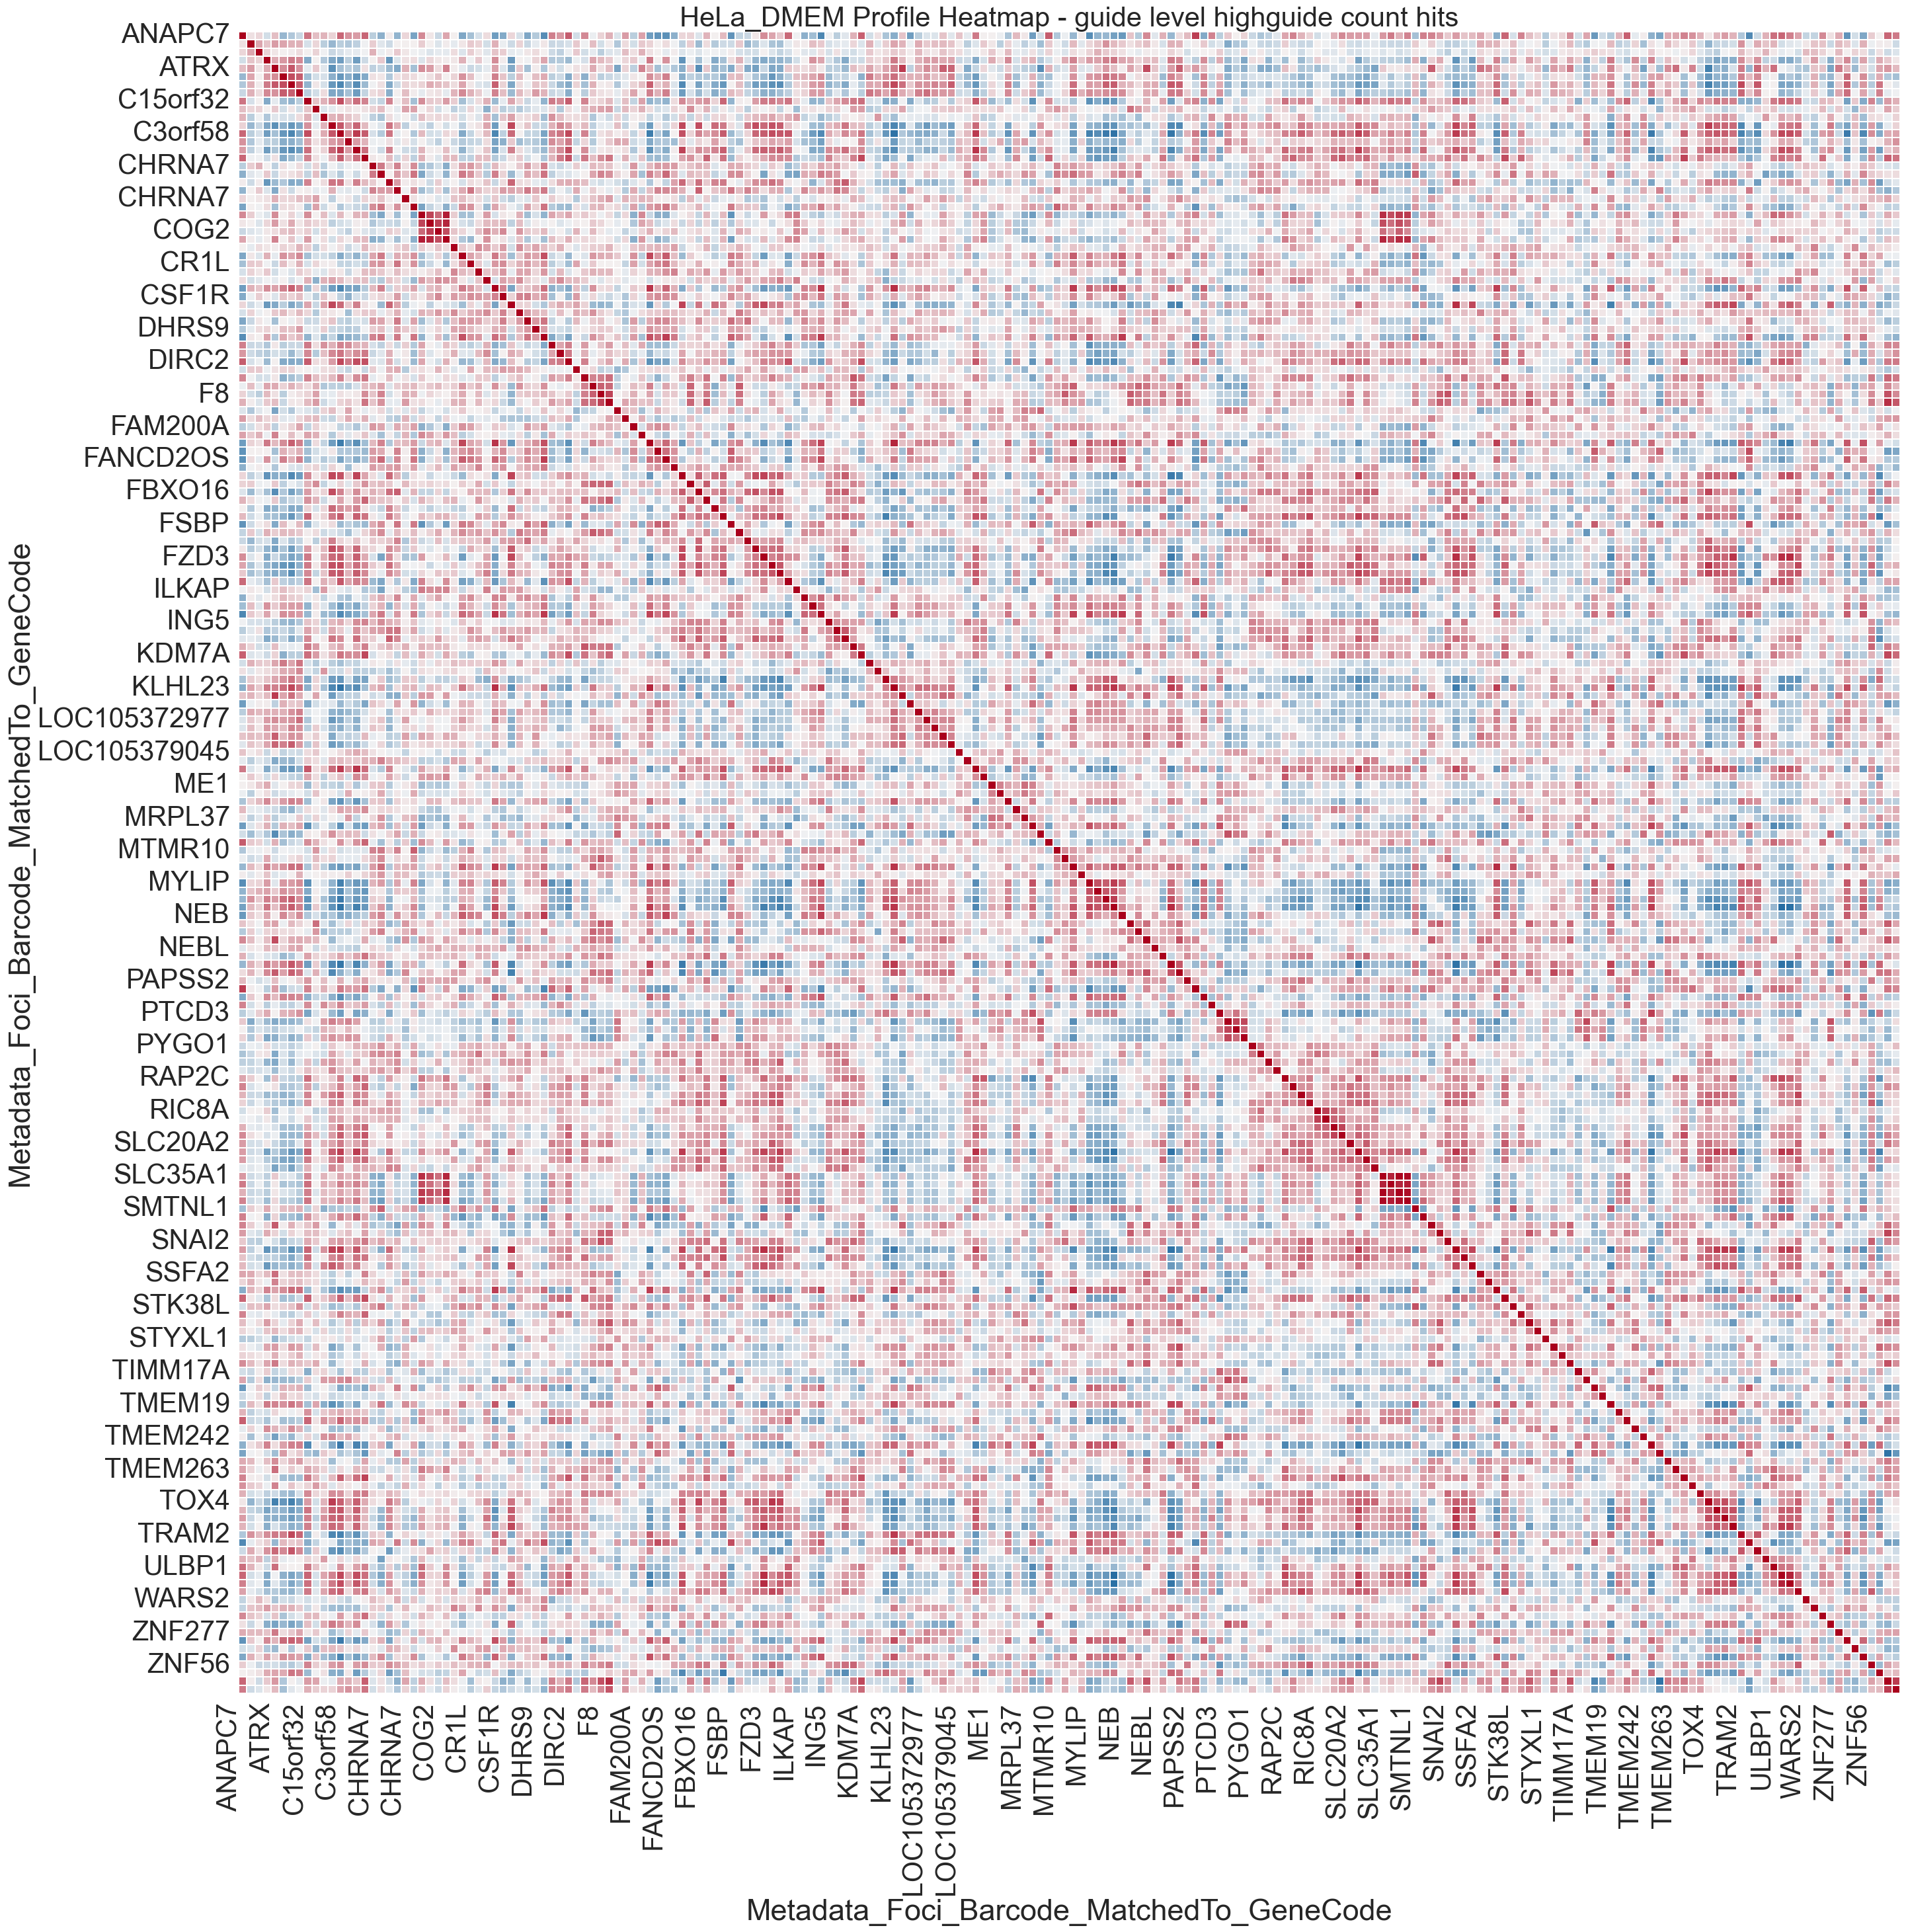

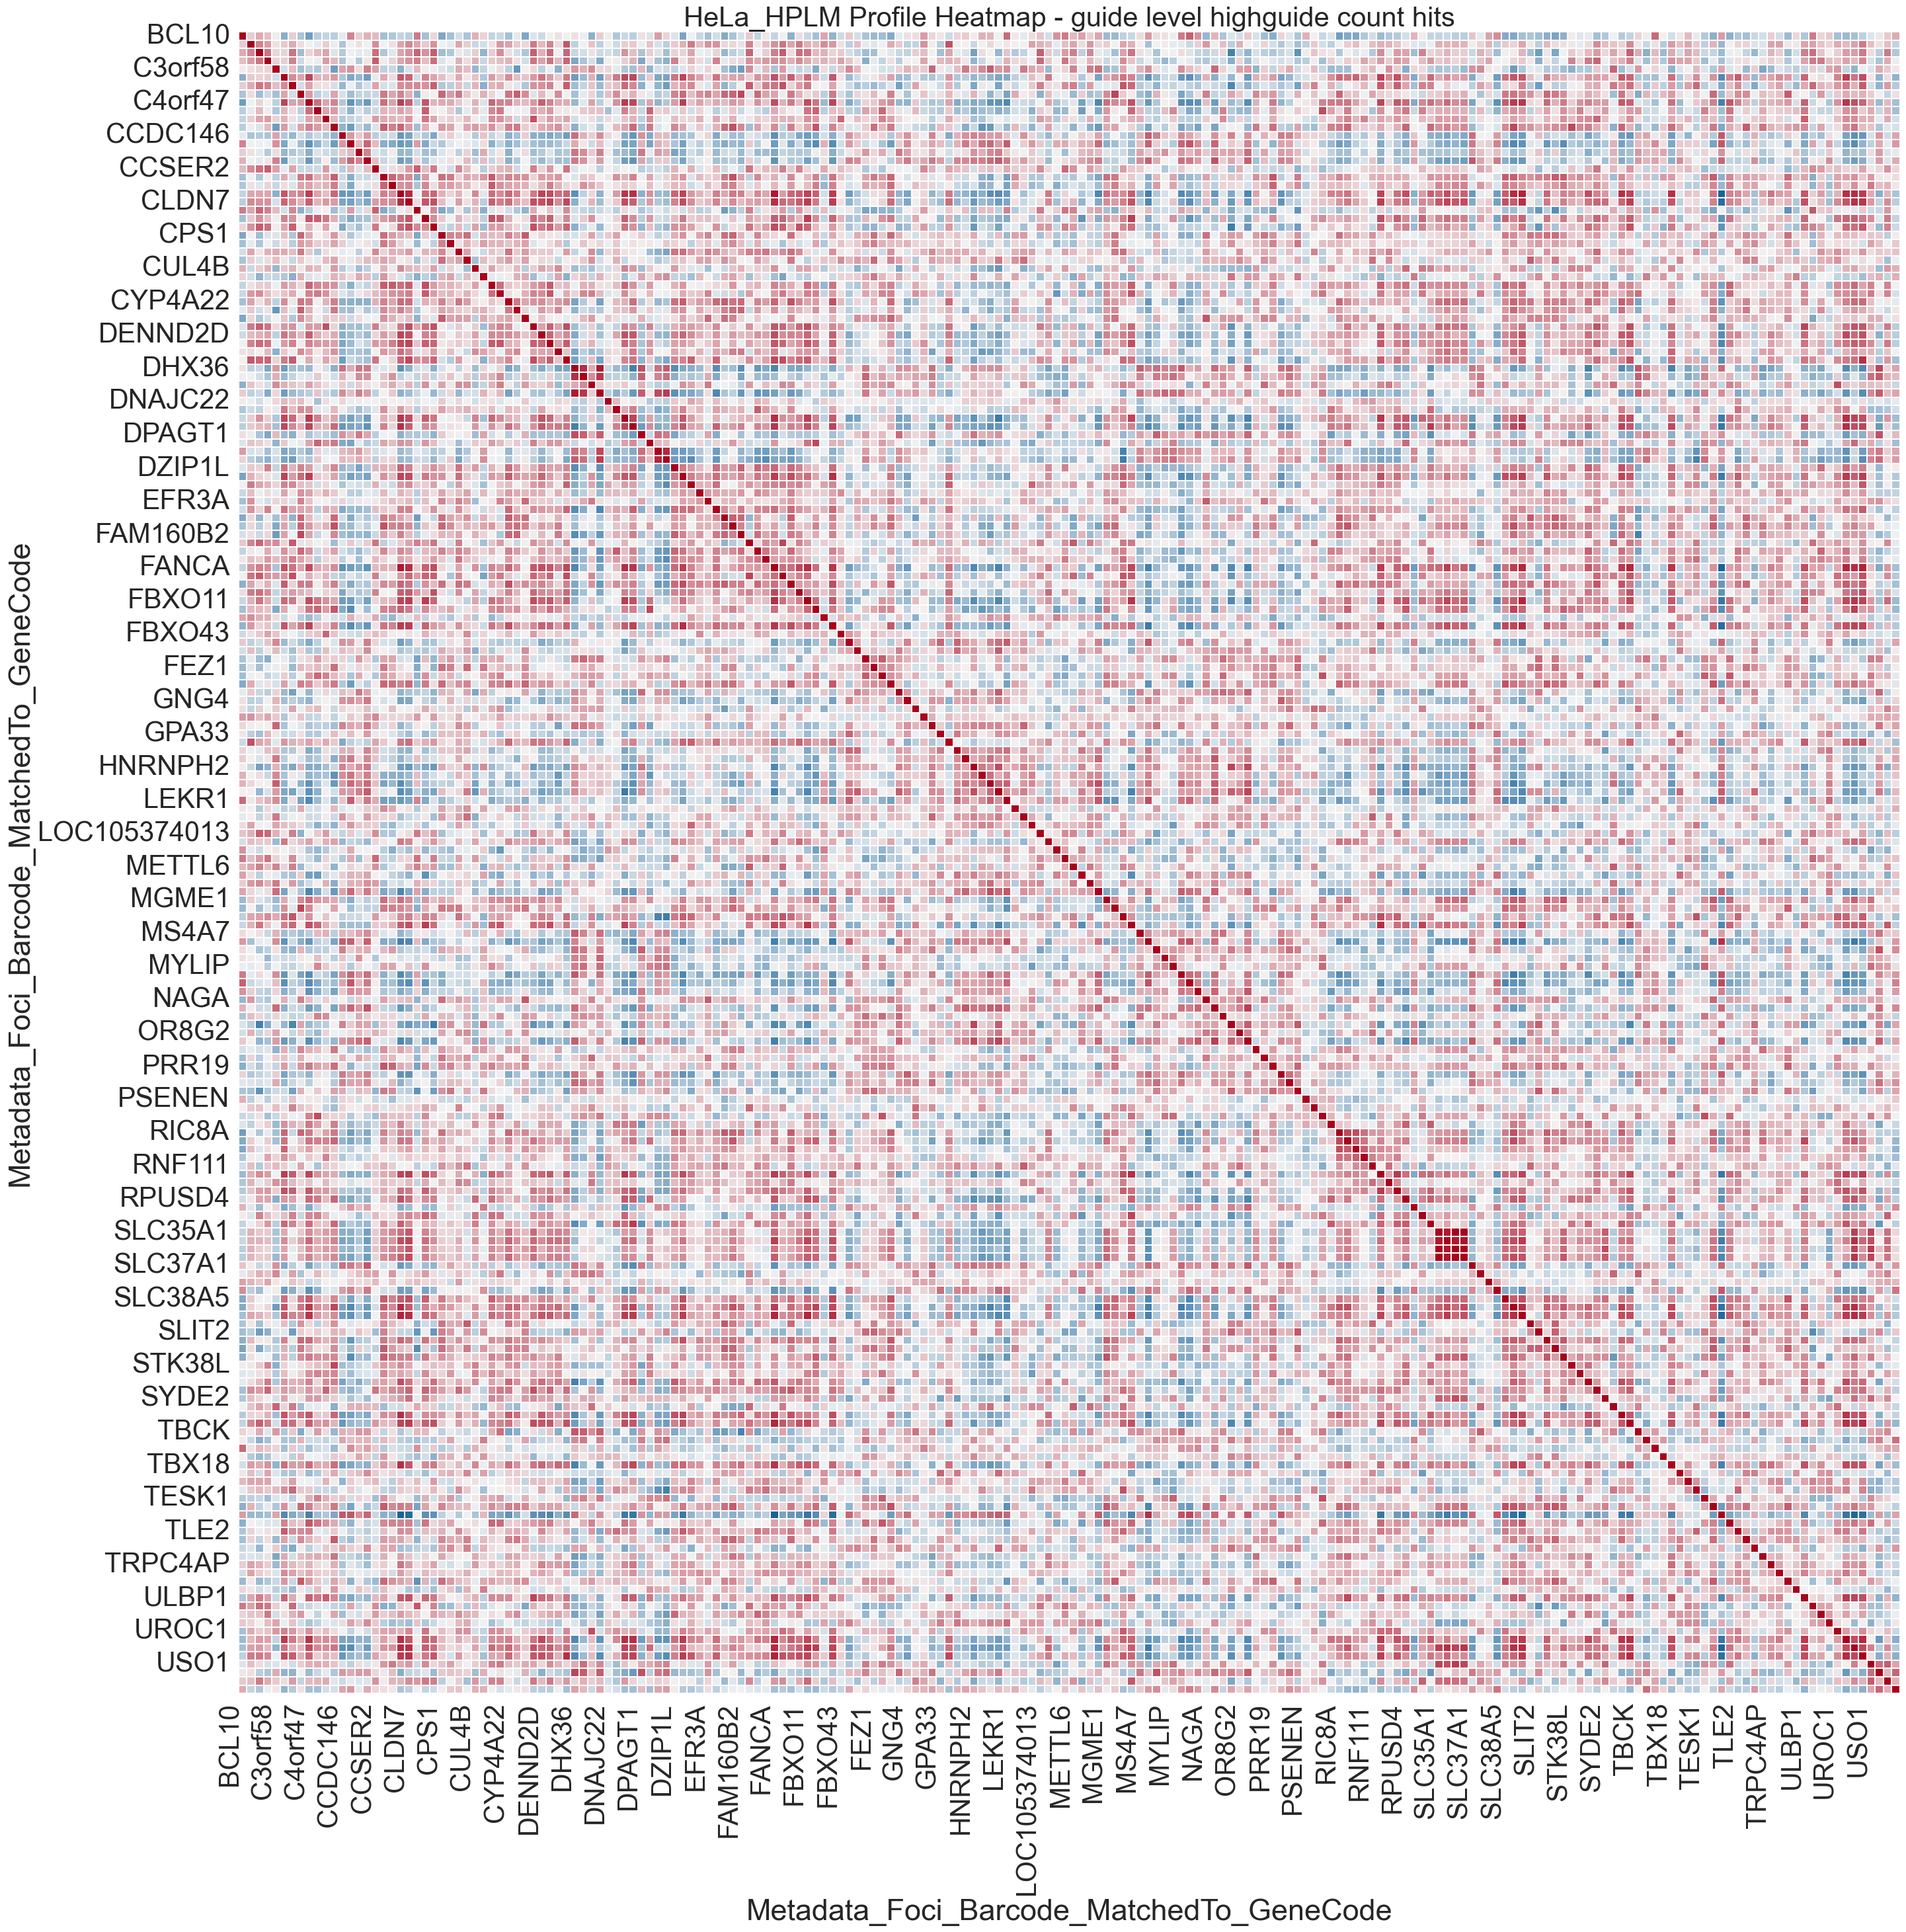

In [7]:
# Subset the data and draw heat-maps for guides with high guide count
def draw_high_count_heat_maps(counts, guide_count, hit_list, profile_df, data_set, font_scale):
    hit_counts = counts[counts['Metadata_Foci_Barcode_MatchedTo_GeneCode'].isin(hit_list)]
    hit_counts = hit_counts.query(f"Cell_Count > {guide_count}").groupby('Metadata_Foci_Barcode_MatchedTo_GeneCode').count()
    high_guide_list = list(hit_counts.query("Cell_Count > 3").index)
    random.seed(13)
    genes_list = sample(high_guide_list,50)
    genes_df = profile_df[profile_df['Metadata_Foci_Barcode_MatchedTo_GeneCode'].isin(genes_list)]
    genes_profiles = genes_df.drop('Metadata_Foci_Barcode_MatchedTo_Barcode',axis=1).set_index('Metadata_Foci_Barcode_MatchedTo_GeneCode')
    heat_map(genes_profiles.T,
                       f'{data_set} Profile Heatmap - guide level highguide count hits',
                       f'{data_set}_profile_heatmap_guide_level_high_guide_count_hits.png',
                       2.7)
    

draw_high_count_heat_maps(A549_counts, 85, A549_hit_list, A549_pca_df, 'A549', 2.7)
draw_high_count_heat_maps(DMEM_counts, 135, DMEM_hit_list, DMEM_pca_df, 'HeLa_DMEM', 2.7)
draw_high_count_heat_maps(HPLM_counts, 106, HPLM_hit_list, HPLM_pca_df, 'HeLa_HPLM', 2.7)


50 genes A549 dataset


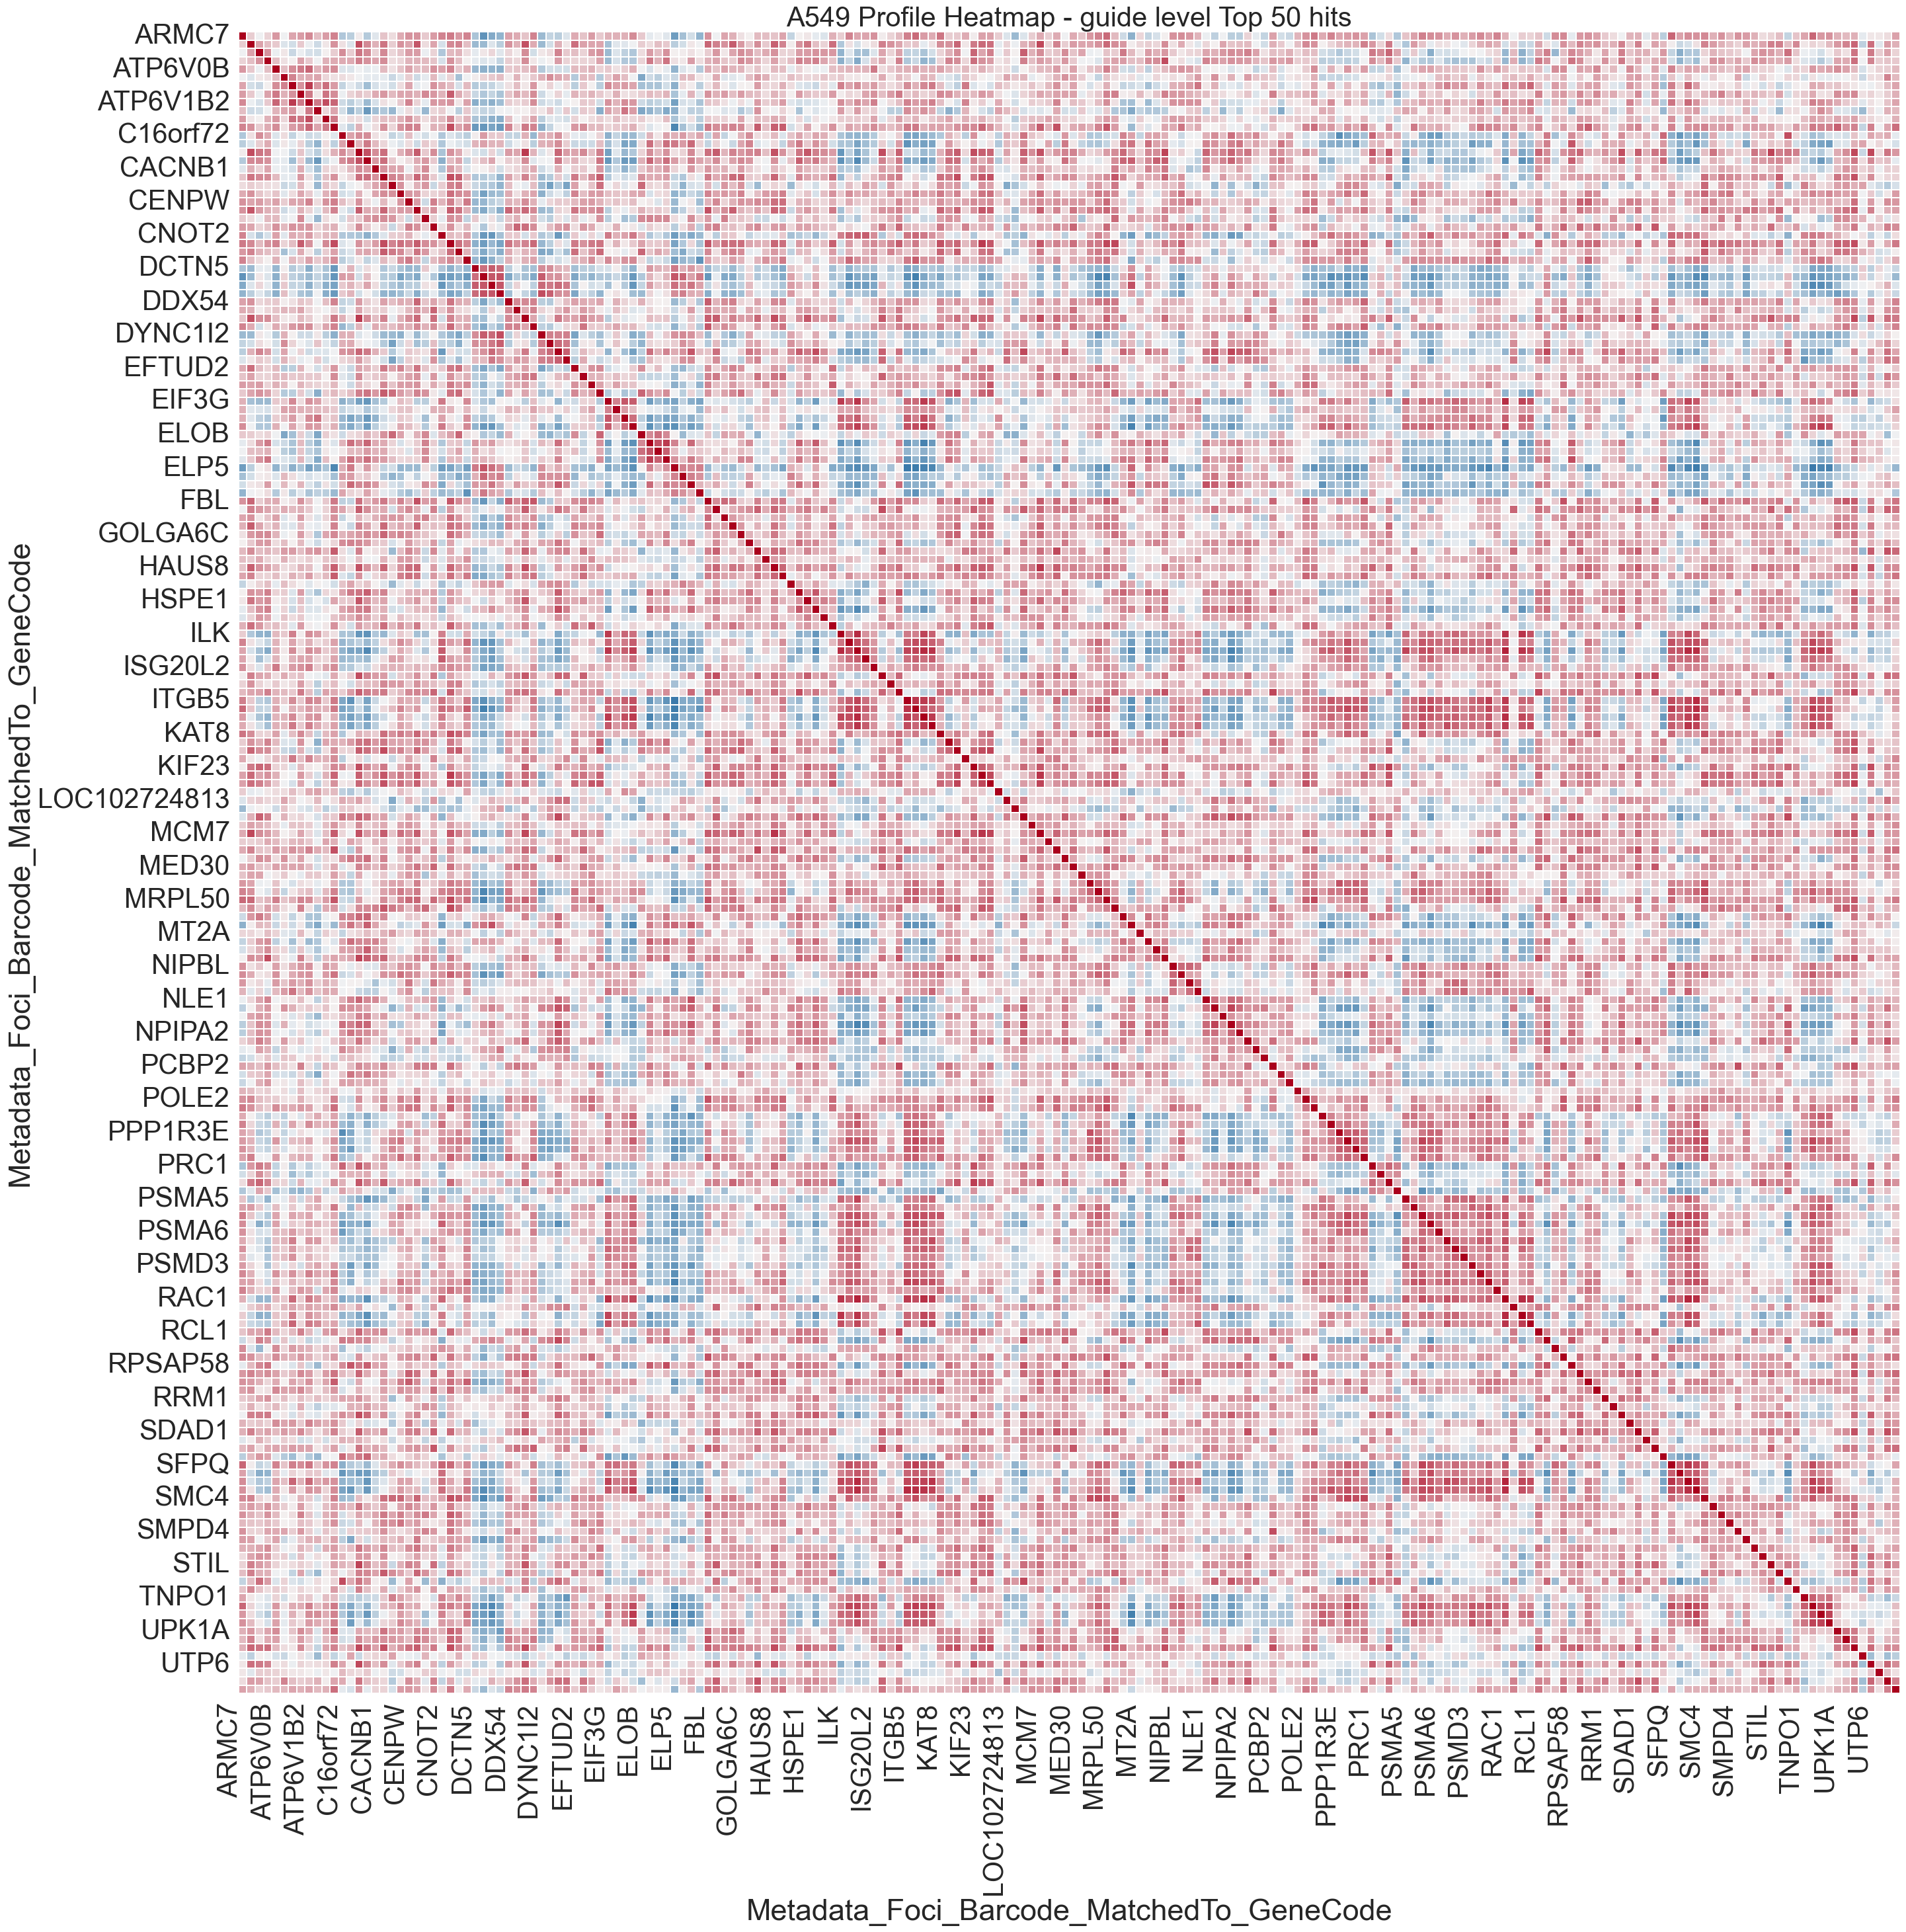

51 genes HeLa_DMEM dataset


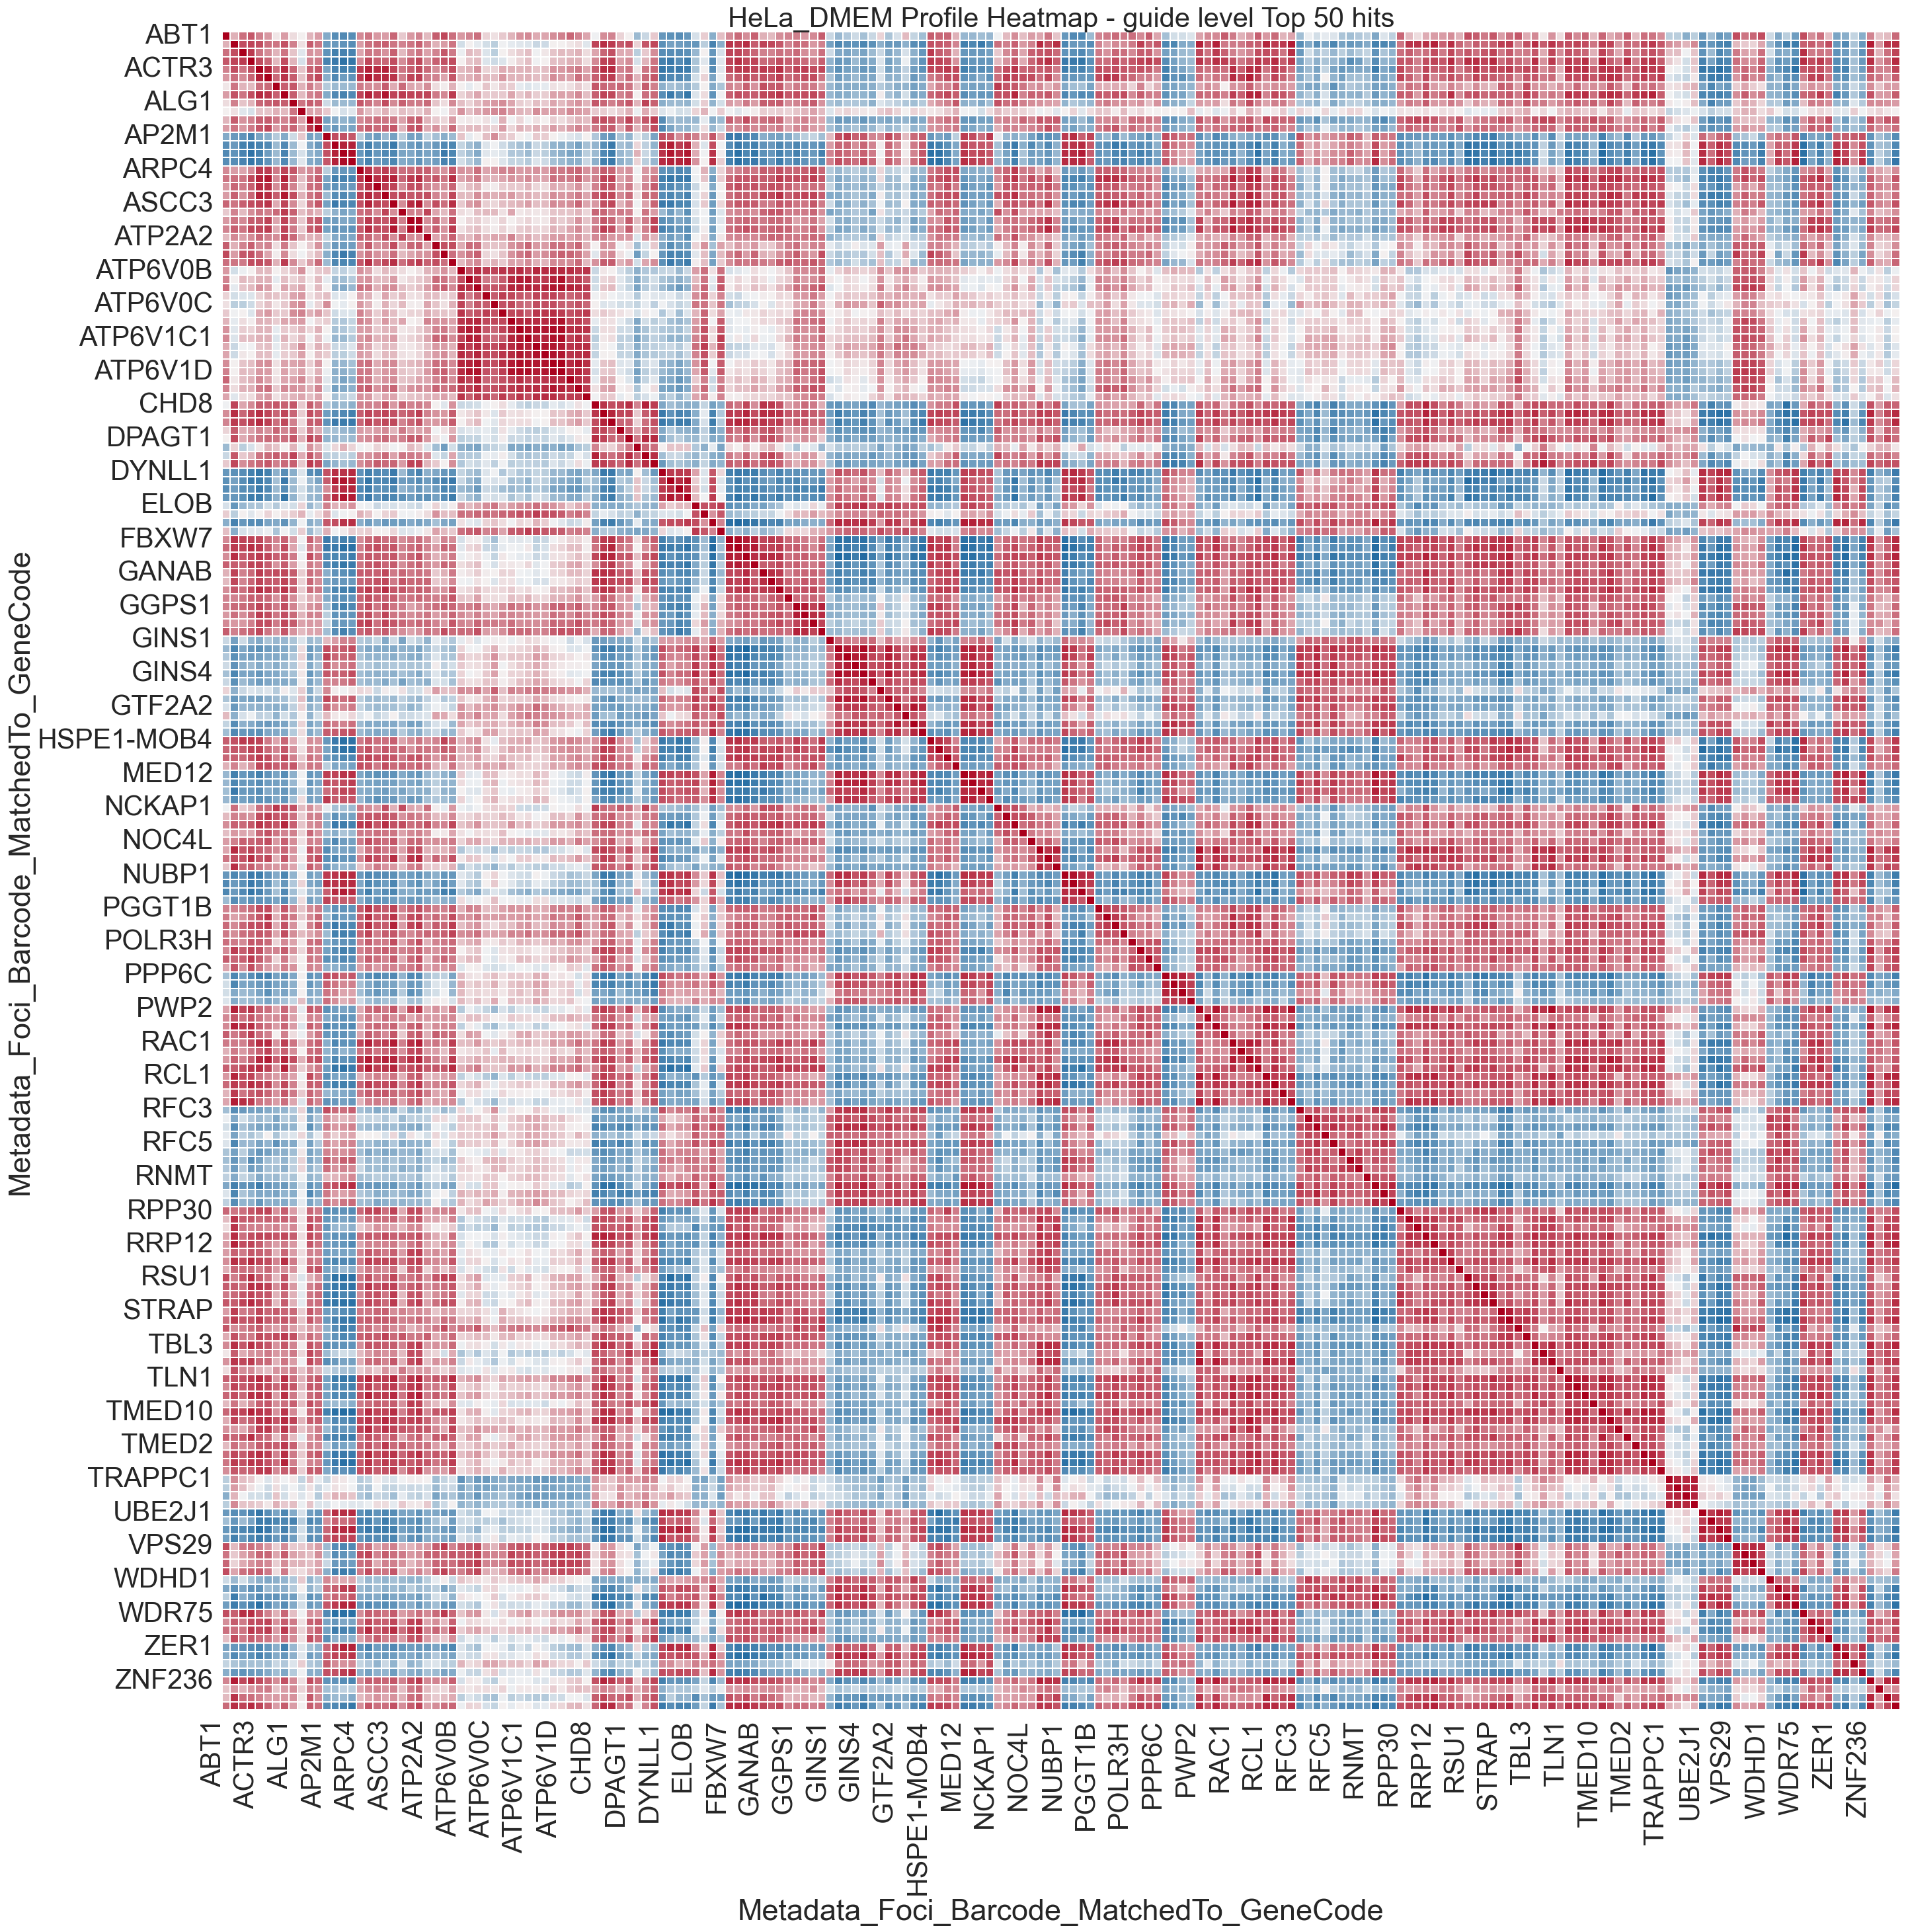

50 genes HeLa_HPLM dataset


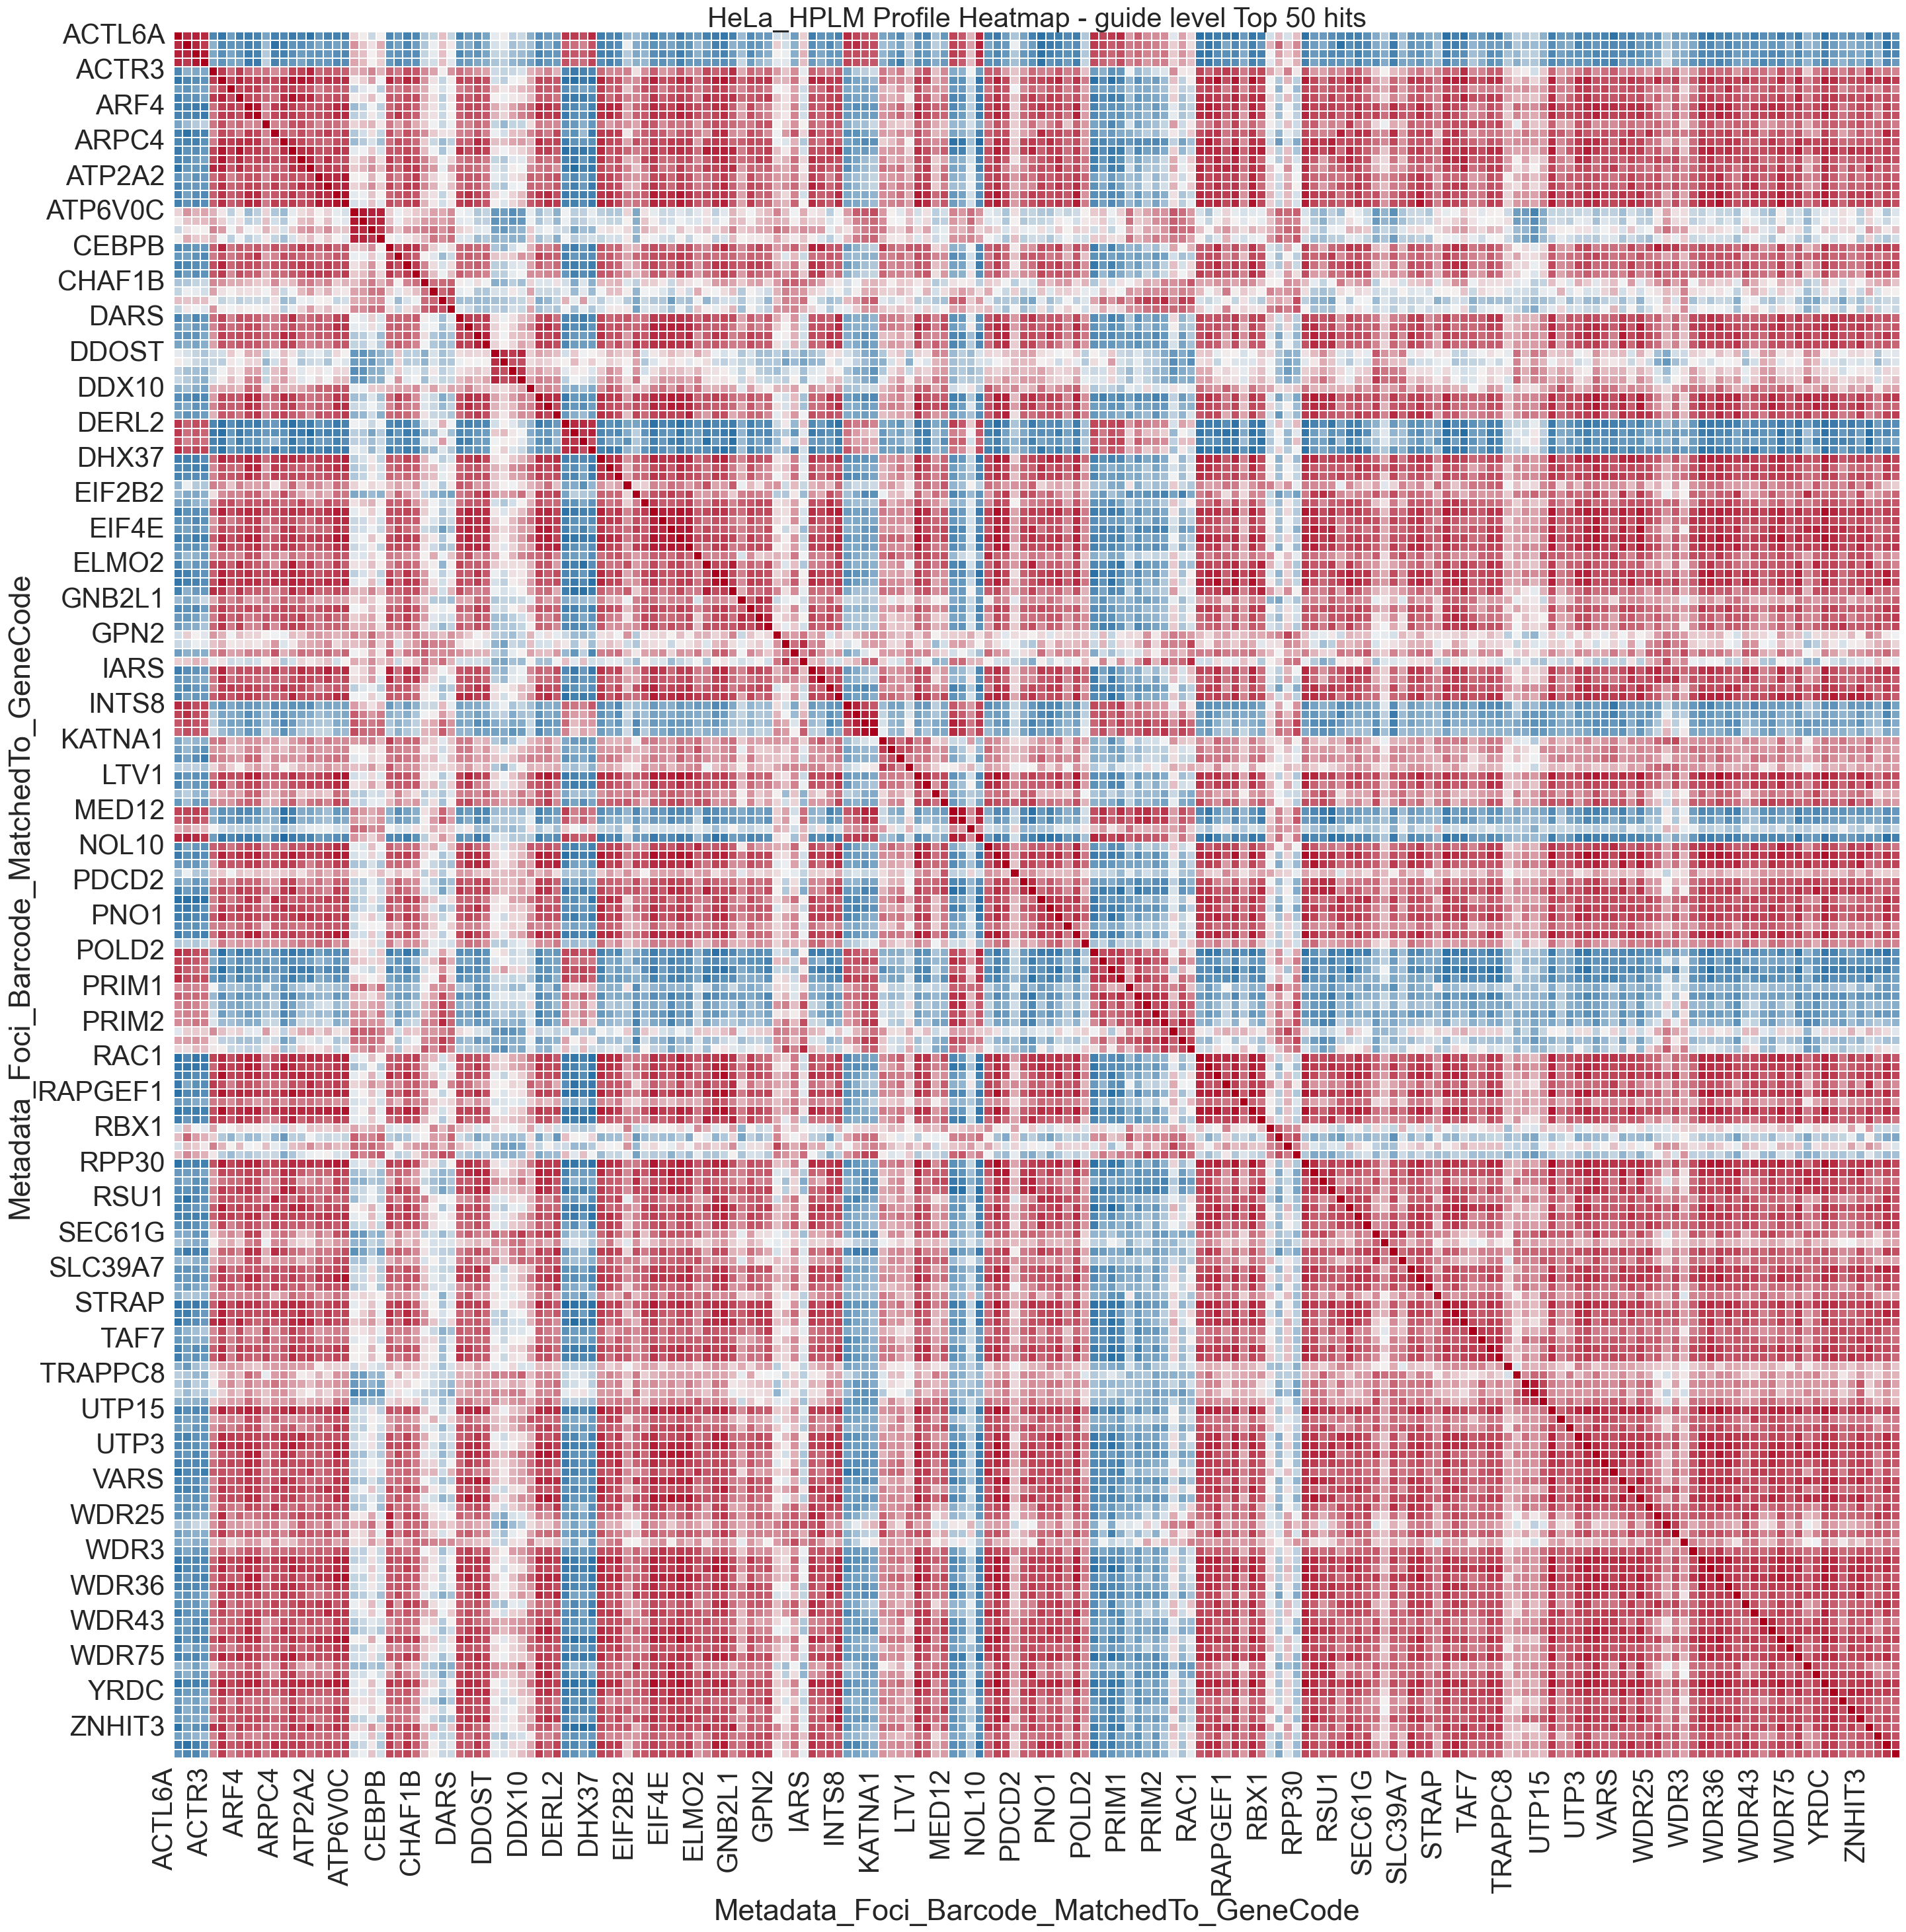

In [8]:
# Subset the data and draw heat-maps for guides with high signal
def draw_top_heat_maps(all_hits_df, profile_df, n_top, data_set, font_scale):
    for i in range(int(all_hits_df.Sum.max()),0,-1):
        genes_lst = list(all_hits_df.query(f"Sum > {i} ").Gene)
        if len(genes_lst) >= n_top:
            break
    print(f'{len(genes_lst)} genes {data_set} dataset')
    genes_df = profile_df[profile_df['Metadata_Foci_Barcode_MatchedTo_GeneCode'].isin(genes_lst)]
    genes_profiles = genes_df.drop('Metadata_Foci_Barcode_MatchedTo_Barcode',axis=1).set_index('Metadata_Foci_Barcode_MatchedTo_GeneCode')
    heat_map(genes_profiles.T,
                       f'{data_set} Profile Heatmap - guide level Top {n_top} hits',
                       f'{data_set}_profile_heatmap_guide_level_top_{n_top}_hits.png',
                       2.7)
    
draw_top_heat_maps(A549_all_hits, A549_pca_df, 50, 'A549', 2.7)
draw_top_heat_maps(DMEM_all_hits, DMEM_pca_df, 50, 'HeLa_DMEM', 2.7)
draw_top_heat_maps(HPLM_all_hits, HPLM_pca_df, 50, 'HeLa_HPLM', 2.7)


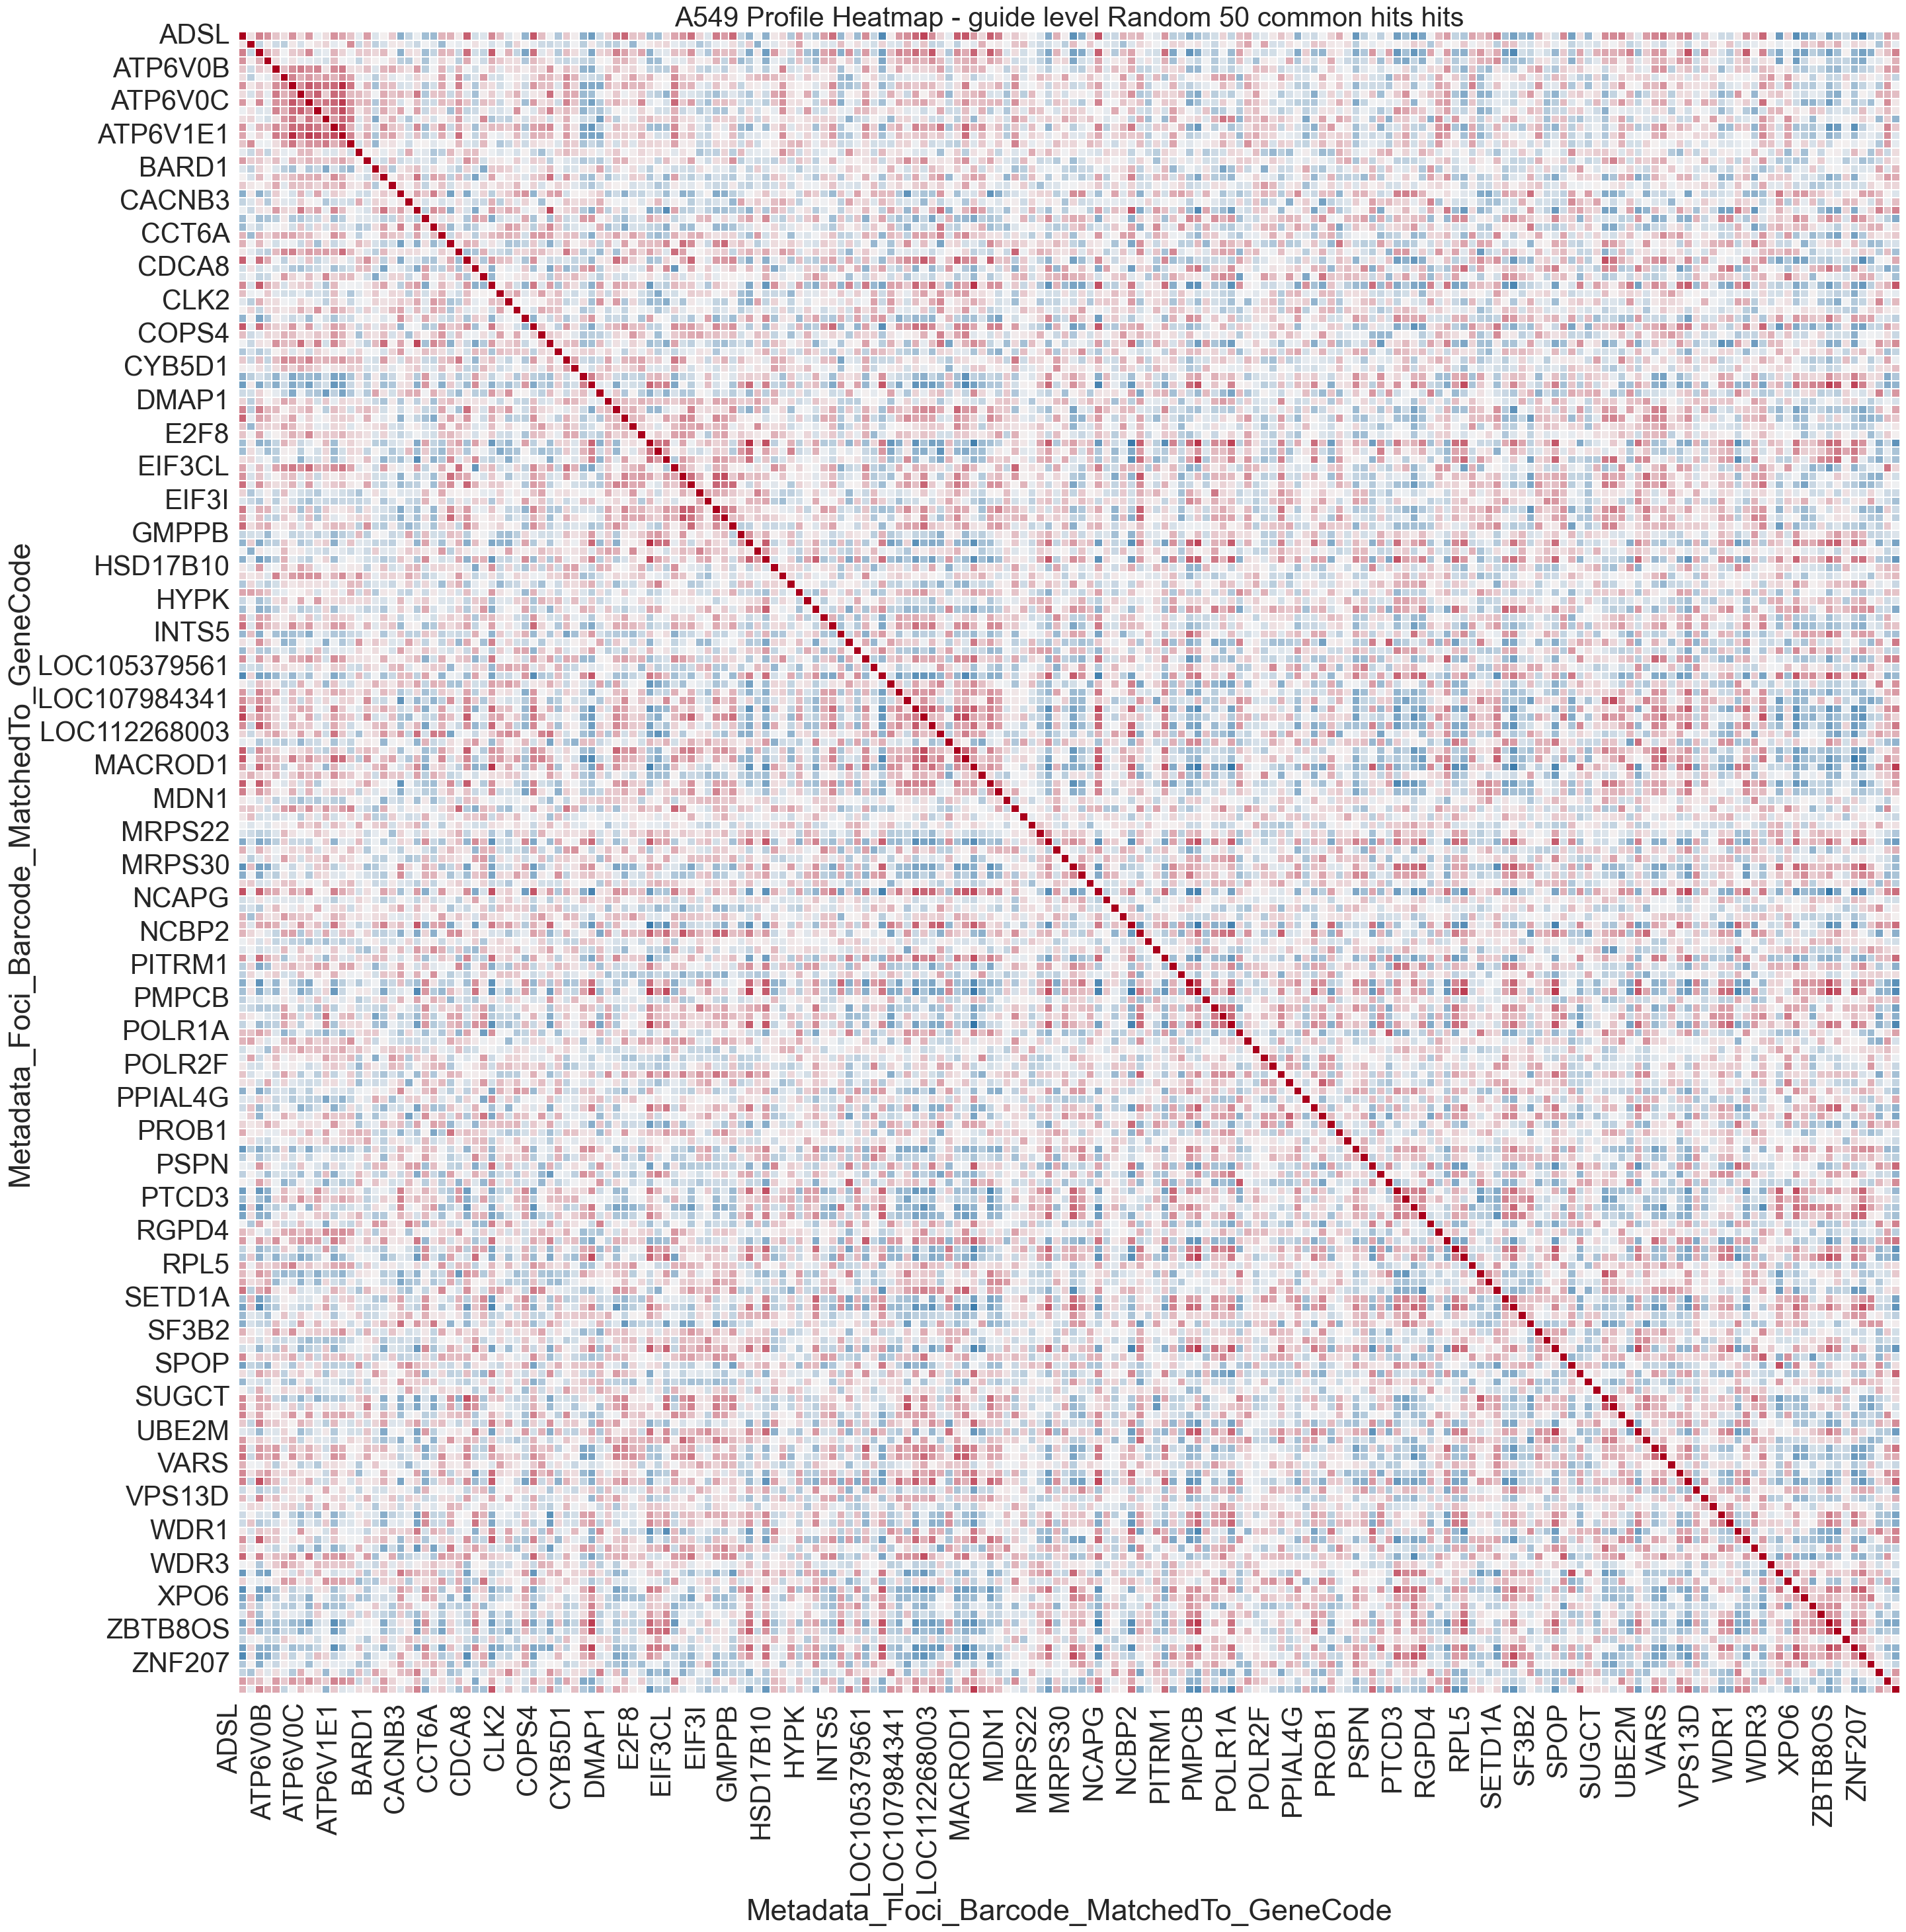

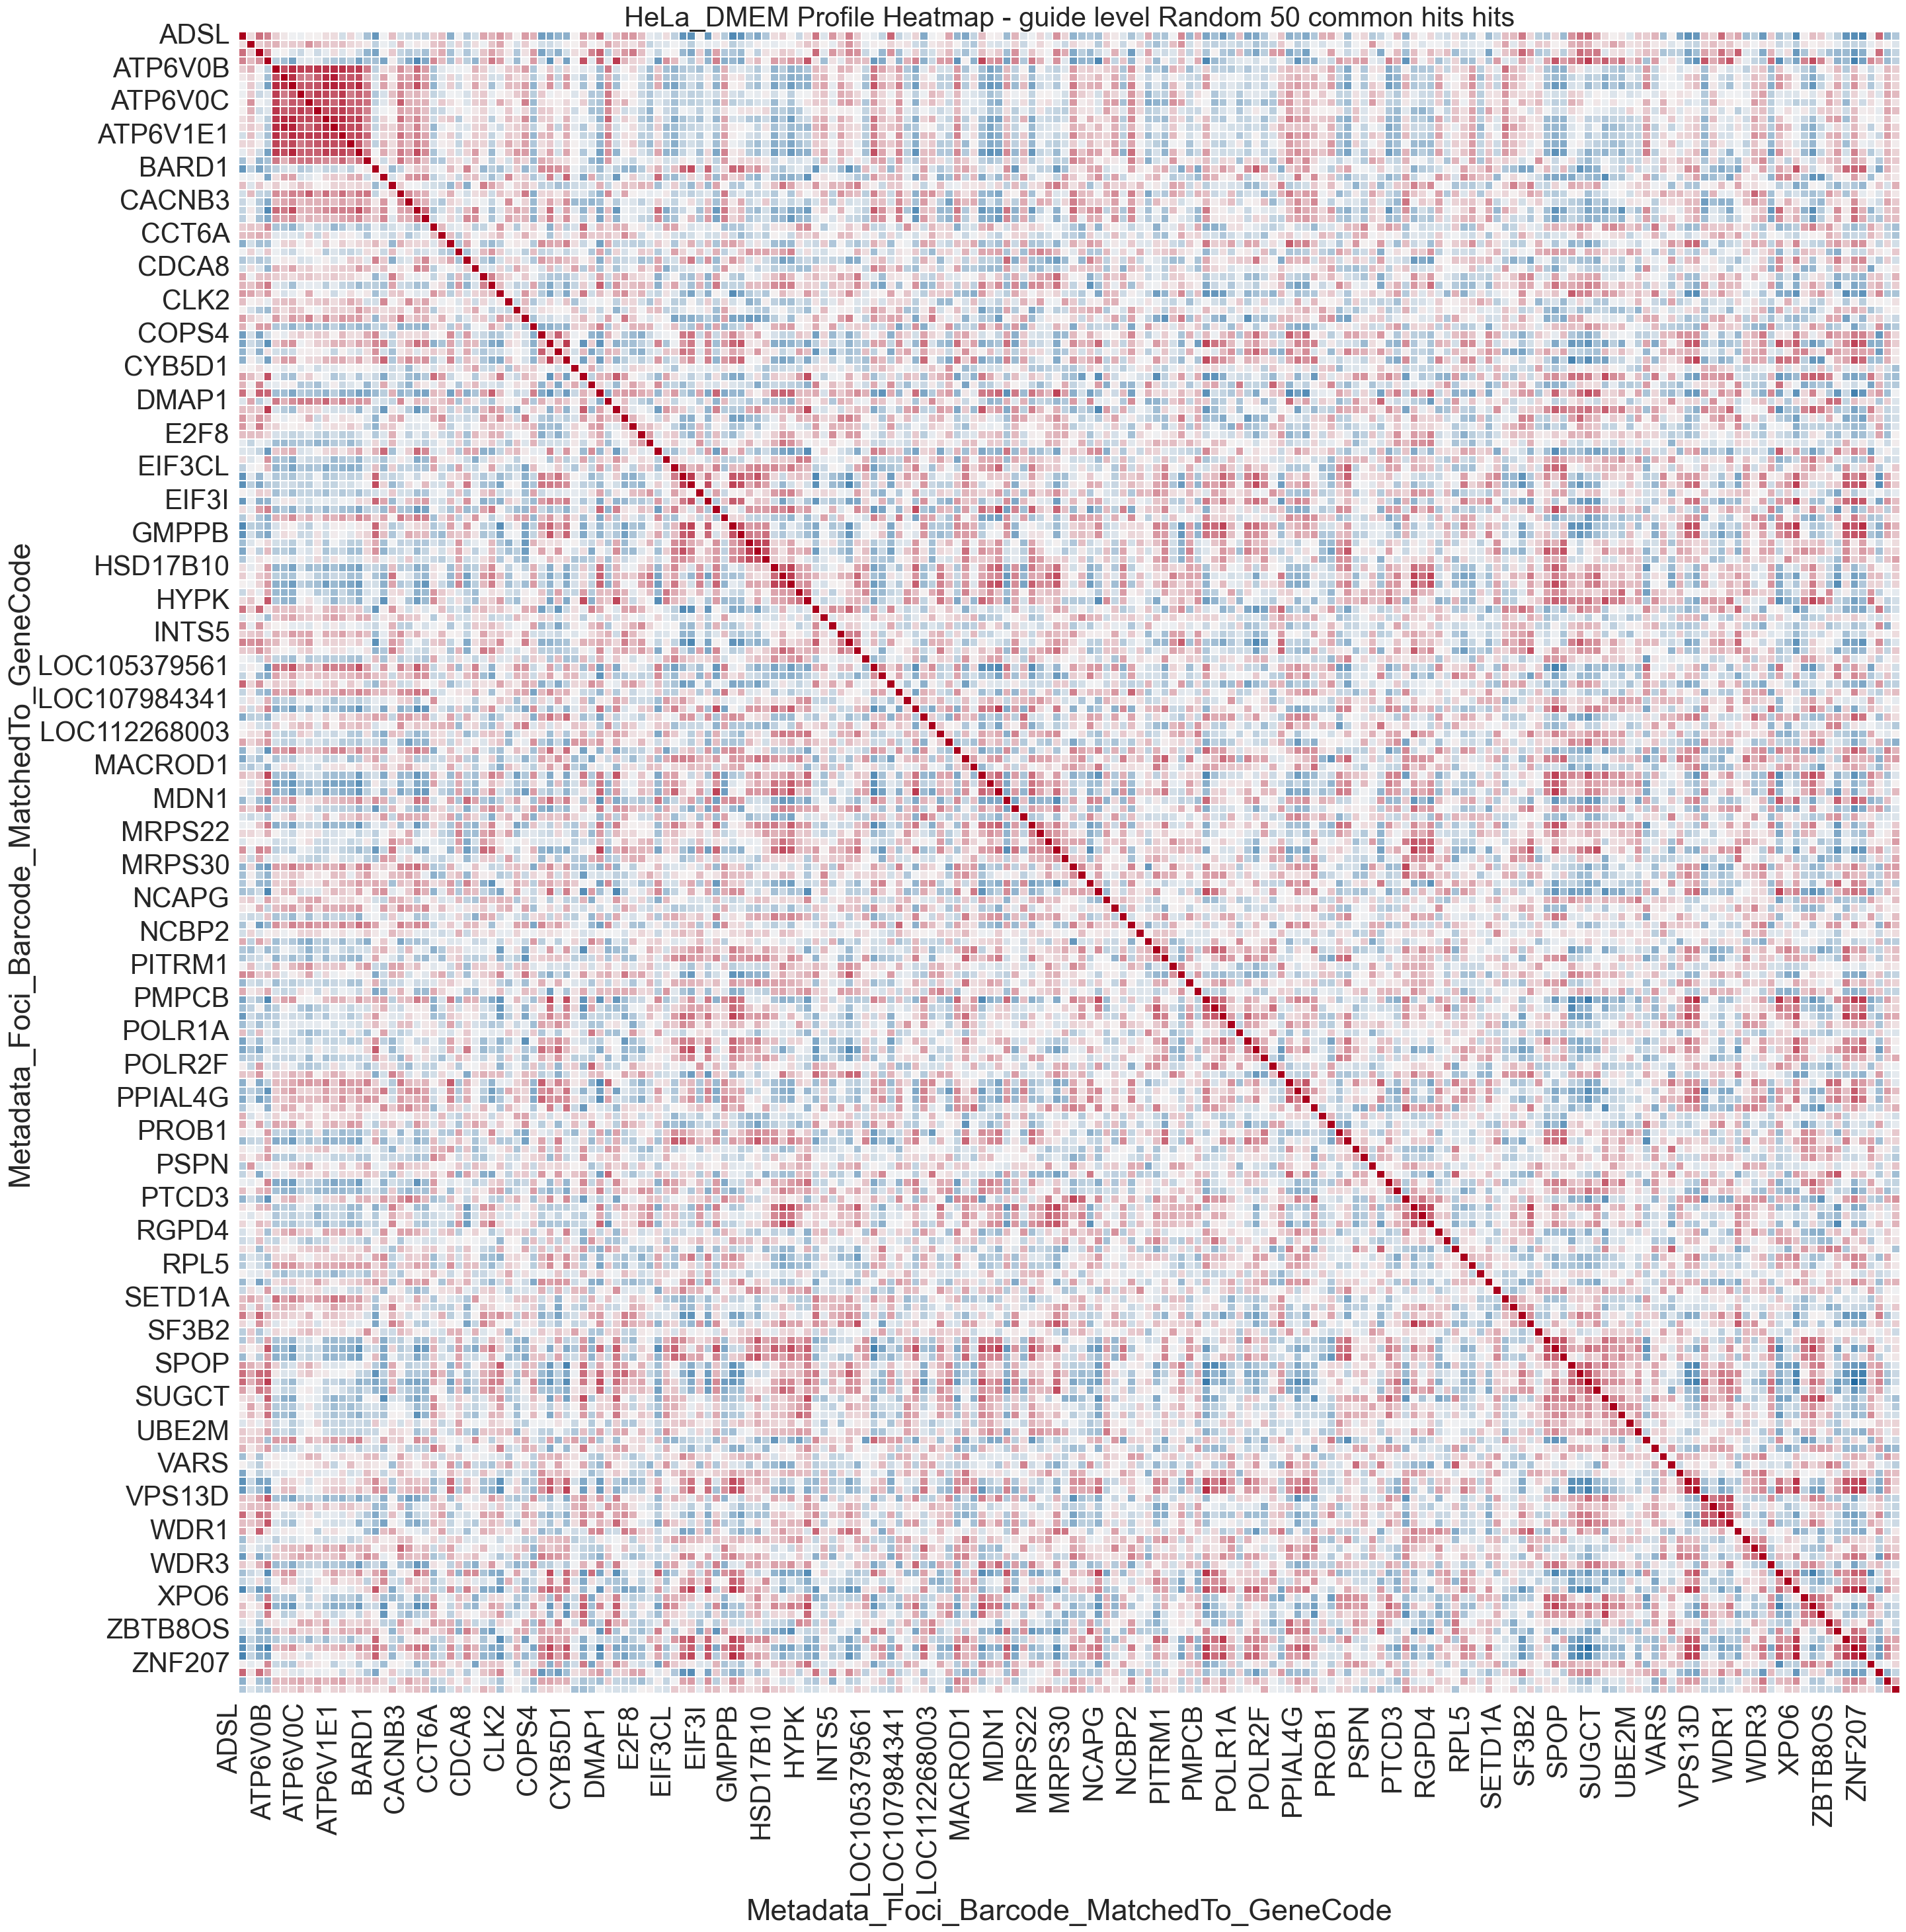

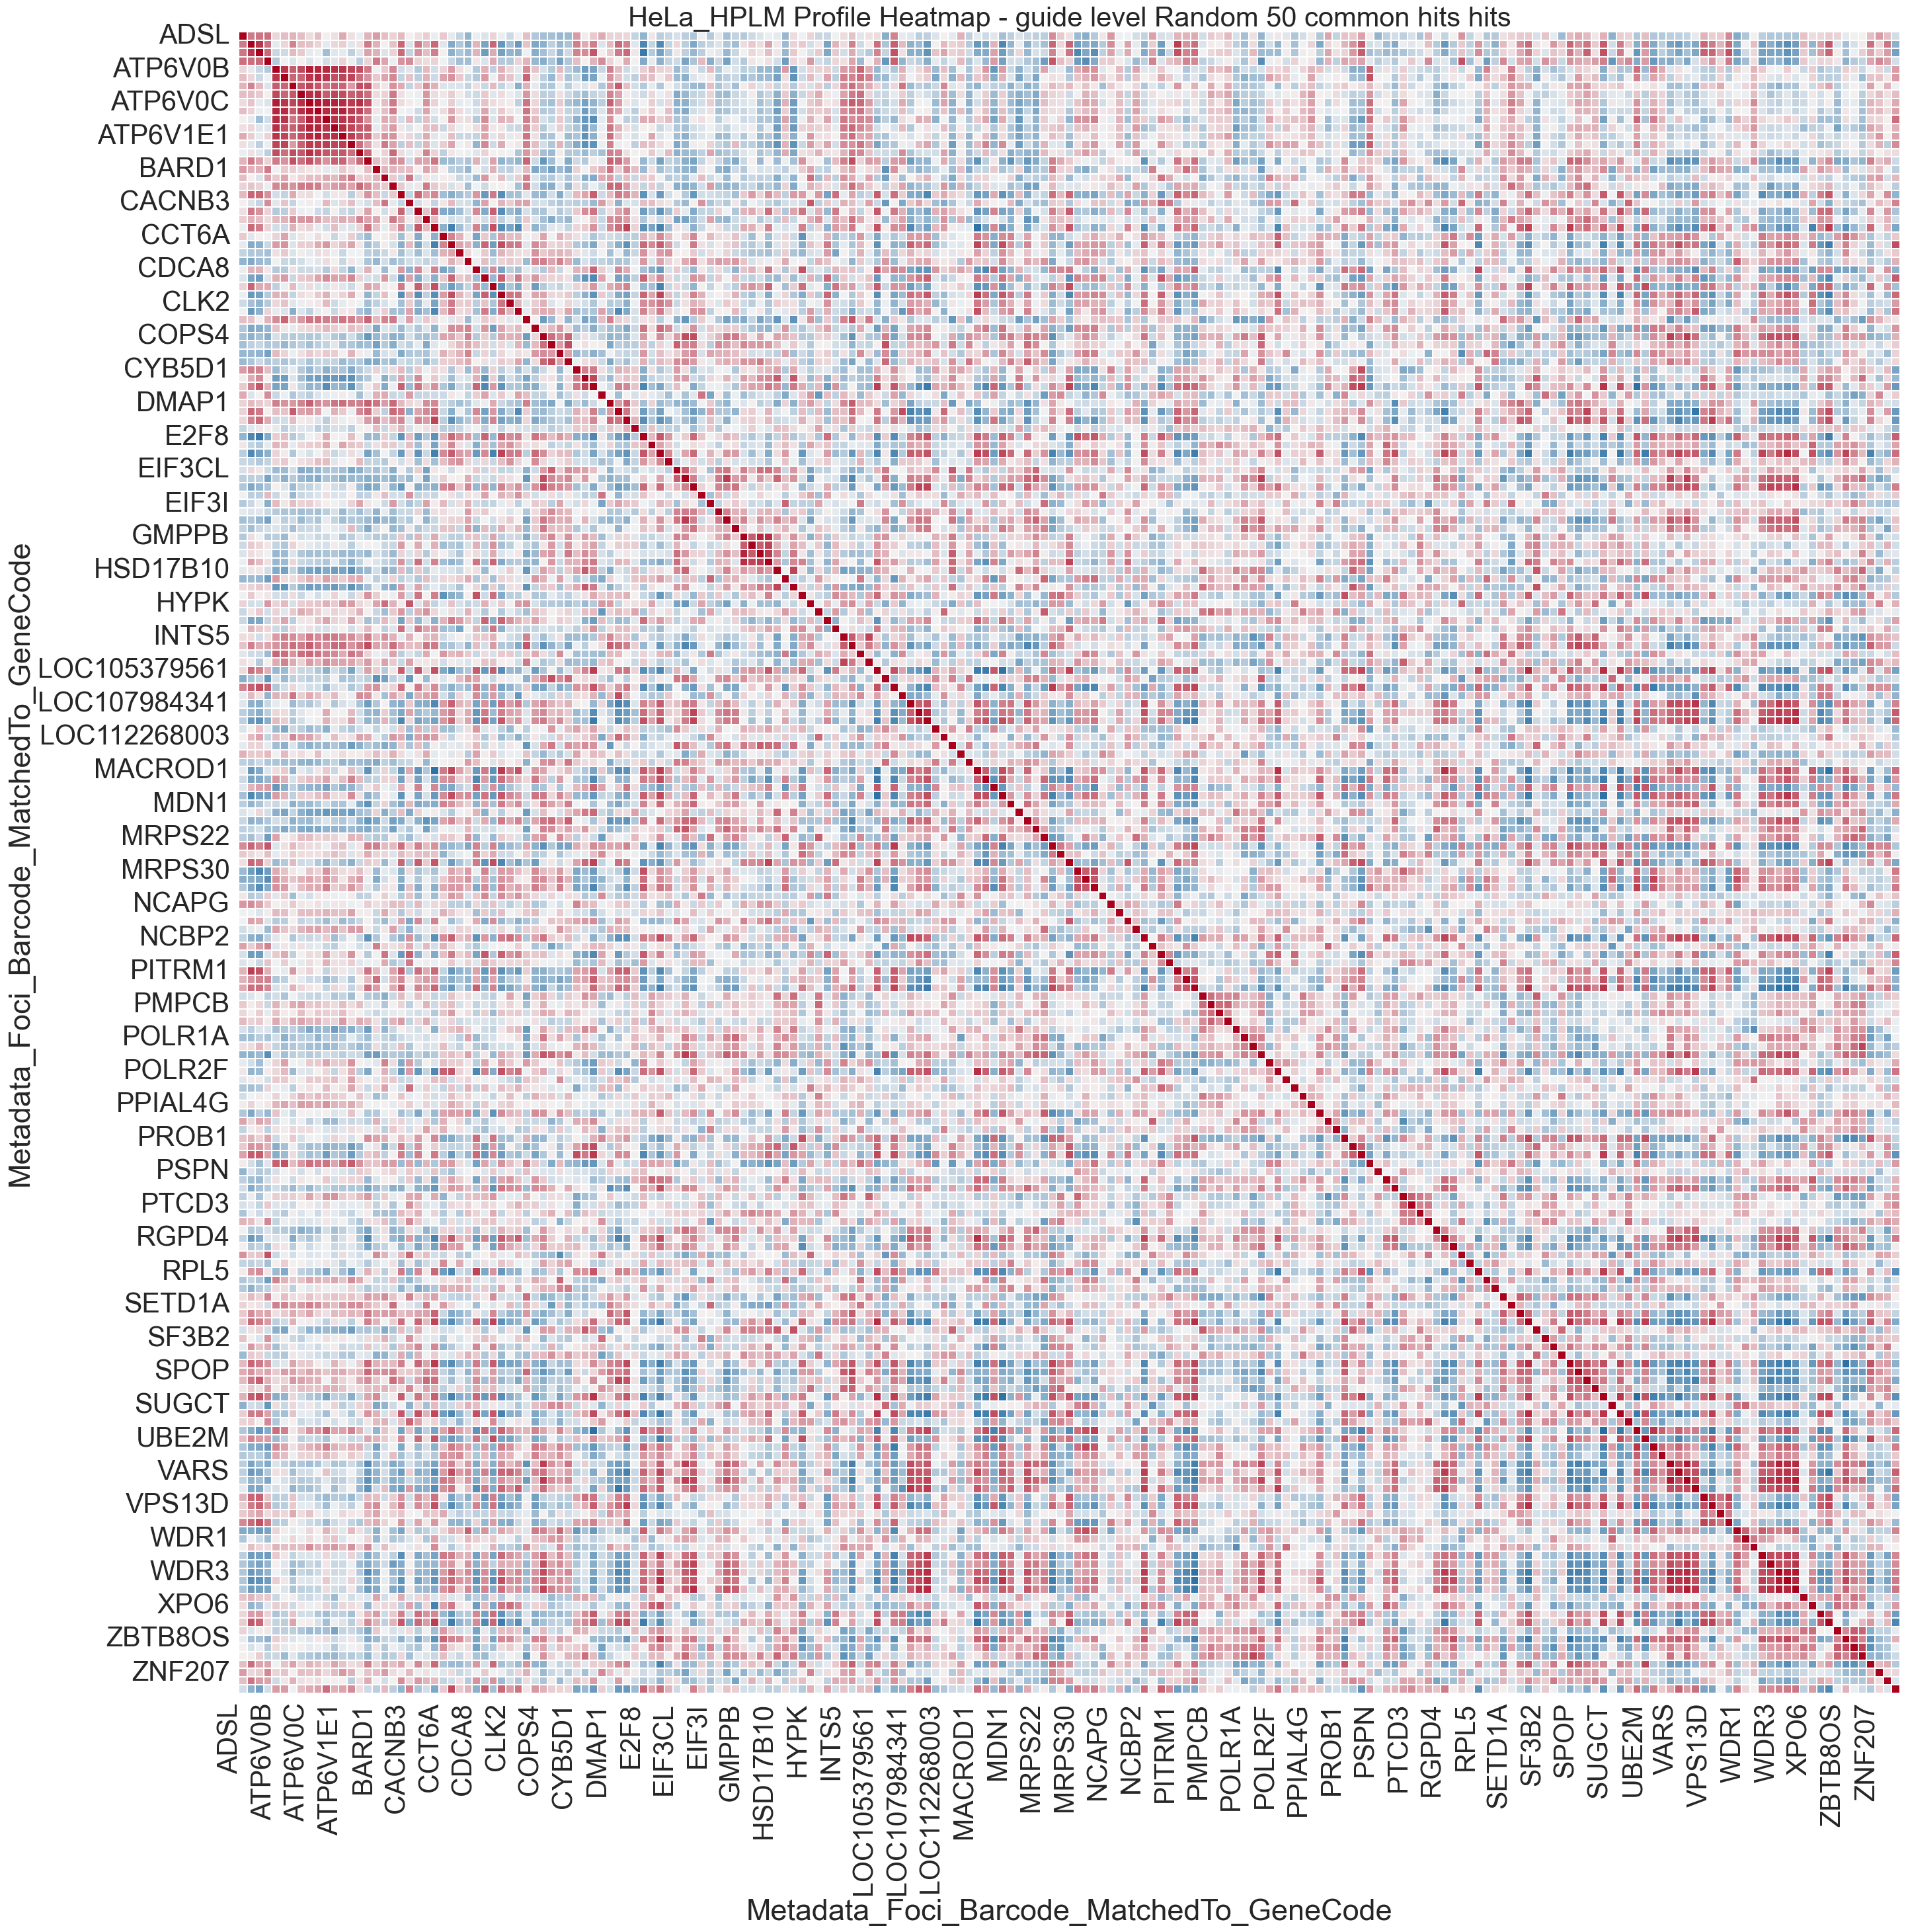

In [9]:
# Subset the data and draw heat-maps for guides from common hit list
def draw_functional_heat_maps(gene_set, genes_lst, profile_df, data_set, font_scale):
    
    genes_df = profile_df[profile_df['Metadata_Foci_Barcode_MatchedTo_GeneCode'].isin(genes_lst)]
    genes_profiles = genes_df.drop('Metadata_Foci_Barcode_MatchedTo_Barcode',axis=1).set_index('Metadata_Foci_Barcode_MatchedTo_GeneCode')
    heat_map(genes_profiles.T,
                       f'{data_set} Profile Heatmap - guide level {gene_set} hits',
                       f'{data_set}_profile_heatmap_guide_level_{gene_set}_hits.png',
                       2.7)
    
gene_set = 'Random 50 common hits'
common_hits = [i for i in A549_hit_list if i in DMEM_hit_list and i in HPLM_hit_list]
random.seed(10) 
random_common_hits = sample(common_hits,50)
draw_functional_heat_maps(gene_set, random_common_hits, A549_pca_df, 'A549', 2.7)
draw_functional_heat_maps(gene_set, random_common_hits, DMEM_pca_df, 'HeLa_DMEM', 2.7)
draw_functional_heat_maps(gene_set, random_common_hits, HPLM_pca_df, 'HeLa_HPLM', 2.7)


